Notebook by **Jakob R. Jürgens** - Final project for the courses **OSE - Data Science** in the summer semester 2021 and **OSE - Scientific Computing** in the winter semester 2021/2022 - Find me at [jakobjuergens.com](https://jakobjuergens.com) <br>
# Outlier Detection in Sensor Data using Functional Depth Measures
---

The best way to access this project is to clone this repository and execute the jupyter notebook and the shiny app locally. Alternatively, on the main site of this repository, there are nbviewer and binder badges set up to directly look at them in the browser.

The following packages and their dependencies are necessary to execute the notebook and the shiny app. If you are executing the code locally, make sure that these packages are provided and that an R Kernel (like irkernel) is activated in the Jupyter notebook. The package **OutDetectR** was written by me in Rcpp and is not available from the usual sources. Instead both the .tar.gz file for installation and the source code are provided in the **Code/OutDetectR** folder. 

In [1]:
suppressMessages(library(devtools))
suppressMessages(library(MASS))
suppressMessages(library(tidyverse))
suppressMessages(library(shiny))
suppressMessages(library(shinydashboard))
suppressMessages(library(largeList))
suppressMessages(library(parallel))
suppressMessages(library(Rcpp))
suppressMessages(library(repr))

options(repr.plot.width=30, repr.plot.height=8)

ci <- Sys.getenv('CI')
if(!(ci == 'true')){
    install.packages('Code/OutDetectR_1.0.tar.gz', repos = NULL, type = 'source')
}
library(OutDetectR)

source("Code/auxiliary/observation_vis.R")
source("Code/auxiliary/distribution_vis.R")
source("Code/auxiliary/updating_vis.R")
source("Code/auxiliary/generate_set_1.R")
source("Code/auxiliary/generate_set_2.R")
source("Code/auxiliary/generate_set_3.R")

If you are in posession of the original Endanzug data set, convert it to a .RDS object using the provided function **data_prep()** from the package written for this project. Set the path to the RDS-object here. As it is property of Daimler AG, it is not included in the repository.

In [ ]:
real_data <- FALSE
if(real_data){
    endanzug_path <- '~/F/data_local/Projekt_AMEIUS_Daten/'
    endanzug_data <- readRDS(file = paste0(endanzug_path, 'schra.RDS'))
}

## Table of Contents
---
1. [Introduction](#introduction)
2. [Observation Structure](#observation)
3. [The Algorithm](#algorithm)
4. [h-modal depth](#h-modal)
5. [Difficulties due to the Data](#difficulties)
6. [Sampling Approach](#sampling)
7. [Finding Comparable Sets of Observations](#comparables)
8. [Description of Full Procedure for Existing Data sets](#procedure)
9. [Updating](#updating)
10. [Implementation](#implementation)
    1. [Grid Approximation](#impl_grid) 
    2. [Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid](#impl_algorithm)
    3. [Sampling Approach](#impl_sampling)
    4. [Dynamic Splitting](#impl_splitting)
    5. [Full Procedure](#impl_full)
    6. [Updating](#impl_upd)
11. [How to use the package?](#how_to)
    1. [No Sampling](#no_sampling)
    2. [Sampling](#sampling)
    3. [Full Procedure: Sampling and Stretching](#full)
    4. [Updating in the Full Procedure](#upd_full)
12. [Endanzug-Data](#application)
13. [Limitations](#limitations)
14. [Shiny App](#shiny)
15. [Outlook](#outlook)
15. [Sources](#sources)

## Introduction <a name="introduction"></a>
---
This project is part of a cooperation with **Daimler AG** and deals with outlier detection in sensor data from production processes. <br>
It serves as my final project for the courses **OSE - Data Science** (summer semester 2021) and **OSE - Scientific Computing for Economists** (winter semester 2021/2022).

The primary data set used in this project deals with the relation of angle and torque during the process of tightening a bolt in a screwing connection. The corresponding data set will be called "Endanzugsproblem" in the following notebook and contains ~350000 observations of what can be imagined as a function that maps angles to torque. The following schematic will give an idea of what the data set represents and what the problem is:

<img src="material/SchraubdatenPrinzipskizze.png">

To clarify some things about this simplified schematic:
* The so-called Endanzug is only part of the tightening process, but the section of the observation happening before it is not subject of this analysis
* The focus of this project lies on curves that are "In Ordnung," so observations that do not immediately disqualify themselves in some way by, for example, not reaching the fixed window of acceptable final values
* The observations typically have a high frequency of measuring torque, but the measuring points are not equidistant
* The angles where torque is measured are not shared between observations, but the measuring interval of angles might overlap between observations
* The Endanzug does not start at the same angle for every observation and also does not necessarily start at the same torque
* Outliers can be very general, so methods based on detecting only specific types of outliers may not be able to filter out other suspicious observations effectively. So the optimum would be to have some Omnibus test for outliers

Especially due to the high frequency of measurement and the non-identical points where torque is measured, interpreting each observation as a function and approaching the problem from the standpoint of functional data analysis comes to mind. One method used in functional data analysis to identify outliers is based on what "functional depth measures." Gijbels and Nagy (2017) introduces the idea of depth as follows and then elaborate on the theoretical properties a depth function for functional data should possess:

> For univariate data the sample median is well known
to be appropriately describing the centre of a data
cloud. An extension of this concept for multivariate
data (say p-dimensional) is the notion of a point (in
$\mathbb{R}^p$) for which a statistical depth function is maximized. 

The idea is to define an analogous concept to centrality measures (such as the distance from some central tendency like the median) in a scalar setting for functional data and then use those to determine which functions in a set are typical for the whole population. Due to the more applied nature of this project, I will not go into detail on the theoretical properties of the methods used but focus on giving intuition why the chosen methods make sense in this context.

The main inspiration for my approach to the problem of detecting outliers in a data set such as the one described above is the paper "**Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels**" by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I will describe their algorithm, then present my extensions and my implementation and finally apply it to three simulated data sets mimicking the "Endanzugsproblem" as the original data is property of Daimler AG, which I cannot make public.

## Observation Structure <a name="observation"></a>
---
For clarity, I will show the typical structure of one observation and define a couple of objects I will refer to later. To give context for the later choices of data generating processes, it is helpful to know that the physical process of tightening a bolt is typically associated with a linear relationship between angle and torque (at least in the relevant parts of the tightening process). This approximation is good for the parts of the tightening process that are part of the "Endanzug." Therefore, simulations in the later parts of this notebook typically assume an approximately linear process as the data generating process for non-outliers.

One observation in a data set might look as follows.

<img src="material/observation.png" width="1000" align="center">

| Observation 	| 1    	| 2    	| 3    	| 4    	| 5    	| 6    	| 7    	| 8    	| 9    	| 10   	| 11   	| 12   	| 13   	| 14   	| 15   	| 16   	| 17   	| 18   	| 19   	| 20   	|
|:-----------:	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|
|    Angle    	| 2.01 	| 2.21 	| 2.91 	| 3.00 	| 3.07 	| 3.95 	| 4.33 	| 4.35 	| 4.41 	| 4.74 	| 4.77 	| 5.06 	| 6.33 	| 6.37 	| 6.41 	| 6.57 	| 7.25 	| 7.32 	| 7.71 	| 7.94 	|
|    Torque   	| 2.02 	| 2.61 	| 3.05 	| 3.16 	| 2.99 	| 4.19 	| 4.24 	| 4.37 	| 4.73 	| 4.89 	| 5.03 	| 5.45 	| 6.32 	| 6.18 	| 6.22 	| 7.06 	| 7.30 	| 7.59 	| 7.99 	| 8.06 	|

* The red diamonds represent measurements of torque that were taken at a recorded angle.
* The blue lines are an example of **linear interpolation** between the points that were actually measured. This will become important later on.
* The **measuring interval** marked in green is the convex hull of angles where measurements were taken for this observation.

The data set contains many of these objects that do not necessarily share these characteristics.

In [ ]:
# Generated using function from auxiliary/observation_vis.R
# source("auxiliary/observation_vis.R")
# obs_vis()

## The Algorithm <a name="algorithm"></a>
---
The idea of Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) is an iterative process that classifies observations as outliers if their functional depth lies below a threshold C, which is determined using a bootstrapping procedure in each iteration. <br> 
The algorithm can be decomposed into two parts:

1. **The iterative process**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i),\: \dots \: ,D_n(x_n)$ for one of the functional depths [...]
    2. Let $x_{i_1},\: \dots,\: x_{i_k}$ be the k curves such that $D_n(x_{i_k}) \leq C$, for a given cutoff $C$. Then, assume that $x_{i_1},\: \dots,\: x_{i_k}$ are outliers and delete them from the sample.
    3. Then, come back to step 1 with the new dataset after deleting the outliers found in step 2. Repeat this until no more outliers are found. 
    
The underlying idea is that observations that are more central in the sense of the chosen depth will have a higher depth assigned to them. So selecting the least deep observations from a data set is reasonable to search for atypical observations. The question of where to draw the border for observations to be classified as abnormal is done using a bootstrapping procedure. <br>

2. **Determining C**: (quoted from Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008))
    1. Obtain the functional depths $D_n(x_i),\: \dots ,\:D_n(x_n)$ for one of the functional depths [...]
    2. Obtain B standard bootstrap samples of size n from the dataset of curves obtained after deleting the $\alpha \%$ less deepest curves. The bootstrap samples are denoted by $x_i^b$ for $i = 1,\: \dots,\: n$ and $b = 1,\: \dots,\: B$.
    3. Obtain smoothed bootstrap samples $y_i^b = x_i^b + z_i^b$, where $z_i^b$ is such that $(z_i^b(t_1), \dots, z_i^b(t_m))$ is normally distributed with mean 0 and covariance matrix $\gamma\Sigma_x$ where $\Sigma_x$ is the covariance matrix of $x(t_1),\: \dots,\: x(t_m)$ and $\gamma$ is a smoothing parameter. Let $y_i^b$, $i = 1,\: \dots,\:n$ and $b = 1,\:\dots,\: B$ be these samples. *
    4. For each bootstrap set $b = 1,\:\dots,\:B$, obtain $C^b$ as the empirical 1% percentile of the distribution of the depths $D(y_i^b)$, $i = 1,\: \dots,\: n$.
    5. Take $C$ as the median of the values of $C^b$, $b = 1,\: \dots,\: B$. 
<br>

This is done as a theoretical derivation of the distribution of depth values for data generated by a specific data generating process is often infeasible. Instead, one drops a fraction of observations $\alpha$ and uses a smoothed bootstrapping algorithm to approximate the corresponding threshold value to remove approximately that fraction of observations in the procedure listed under 1.

*At this point in the algorithm the assumption that the functional observations are observed at a set of discrete points $t_1,\:\dots,\:t_m$ has already been made. <br>

Some important points:
* I decided to deviate from the original procedure proposed by the authors by allowing the user to decide whether to reestimate C in each iteration of the process. The authors present sound arguments as to why keeping C fixed is the better approach, and my testing confirms those. But to keep the possibilities for experimentation open, I opted to implement it in this way nevertheless. In the later stages of this project, I will go into detail on why keeping C constant also has some problems and try to introduce corrections to improve the method developed below.
* The authors recommend a choice of $\gamma = 0.05$ as a smoothing parameter for the bootstrap which I adopted in my applications.
* For the choice of $\alpha$, preexisting information on the data should be used if available. A good way to choose this is the expected fraction of outliers in the data. However, my testing showed that in some cases the choice of this parameter had to be lower than the actual fraction of observations generated by abnormal processes when using a sampling procedure to get better results.

The authors propose three functional depth measures and benchmark them in a simulation setting. Because of their results and the computational cost, which are comparatively small, I chose to use **h-modal depth** for my implementation, which I will introduce in the following.

## h-modal depth <a name="h-modal"></a>
---

Introduced by Cuevas, Febrero-Bande, and Fraiman (2006) h-modal depth is one of three depth measures covered in Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008). I will follow the summary in the latter paper for my overview.  <br> The idea behind this depth is that a curve is central in a set of curves if other curves closely surround it. <br>

In mathematical terms, the h-modal depth of a curve $x_i$ in relation to a set of curves $x_1, \dots, x_n$ is defined as follows: <br>
\begin{equation}
    MD_m(x_i,h) = \sum_{k = 1}^{n} K(\frac{||x_i - x_k||}{h})
\end{equation}

where $K: \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$ is a kernel function and $h$ is a bandwidth. <br>
The authors recommend using the truncated Gaussian kernel, which is defined as follows:
\begin{equation}
    K(t) = \frac{2}{\sqrt{2\pi}} \exp(-\frac{t^2}{2}) \quad \text{for} \quad t>0 \quad \text{and} \quad 0 \quad \text{otherwise}
\end{equation}

and to choose $h$ as the 15th percentile of the empirical distribution of $\{||x_i - x_k|| \, | \, i,k = 1,\:\dots,\:n\}$

I chose to implement the $L^2$ norm - one of the norms recommended by the authors - as it performed better than the $L^{\infty}$ norm (which was also recommended) in my preliminary tests. In a functional setting $L^2$ is defined by:
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\int_a^b (x_i(t) - x_k(t))^2 dt}
\end{equation}

where a and b are the boundaries of the measurement interval. This can be replaced by its empirical version
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 2}^m \Delta_j(x_i(t_j) - x_k(t_j))^2} = \sqrt{\sum_{j = 2}^m (t_j - t_{j-1})(x_i(t_j) - x_k(t_j))^2}
\end{equation}

in case of a discrete set of $m$ observation points shared between observations.

The choice of the functional norm could be adjusted to deal with data resembling different functional forms. This could be part of a possible extension, where different norms are implemented and compared. This might become part of future iterations of this project.

## Difficulties due to the Data <a name="difficulties"></a>
---
### The Endanzug does not start at the same angle for every observation.
In this setting, the fact that the first measurement is taken at different angles is not a problem since the property of interest is the shape of the curve after the Endanzug has started. In real-world terms, the beginning of the "Endanzug" is determined by the first angle where a specific torque is exceeded. The change in torque during the "Endanzug" is of interest and not the position of the "Endanzug" in the whole tightening process. Therefore, all observations can be modified by subtracting the first angle of the "Endanzug" from all angles, effectively **zeroing** the observations. 

At this time, I will focus on problems where zeroing is admissible and elaborate on possibilities of extending the method to scenarios where it is not.

<img src="material/zero.gif" width="1000" align="center">

### After zeroing, the measurement intervals might still not be identical due to differing lengths.
I tried to remedy this remaining problem in the zeroed data set by stretching the measuring intervals to a shared interval while leaving the observed torques unchanged. Excessive stretching, however, could be problematic, as it can lead to similar observations ending up very different. However, putting a conservative limit on stretching should conserve the quality of relationships between observations. This should lead to limited influence on the calculated depths of the functional observations. To do so, I define a parameter $\lambda \geq 1$ called **acceptable stretching** and make observations comparable by stretching their measuring intervals by a factor $\psi_i \in [1/\lambda, \lambda]$ before approximating them using linear interpolation. In an optimal setting, stretching is unnecessary, and employing it leads to trade-offs, so this parameter should be chosen conservatively.

If zeroing as described in 1. is not appropriate, a combination of **acceptable stretching** and **acceptable shifting** could be implemented to increase the size of sets of pairwise comparable functions. This possibility will be explained in later parts of this project.

<img src="material/stretch.gif" width="1000" align="center">

As you can already see in this animation, the acceptable stretching introduces inaccuracies even in an approximately linear setting. Outlier classifications could be quite sensitive to this parameter.

### The angles where torque is measured are not shared between observations.
Assuming that the measuring intervals are identical, I decided to use **linear interpolation** to approximate the observations. This is done to treat them as if they had been observed at a **shared grid of angles** to make them compatible with the simplification of the **h-modal norm** described above. This is only an approximation, but choosing an appropriately fine grid to approximate the observations should limit the influence of this procedure on the calculated functional depths. <br>
Especially in the case of the dataset under consideration in this project, performing this approximation by linear interpolation should not result in large distortions due to the linearity of the described physical process. In other settings, this approximation could lead to bad performance. One example that came to my mind is if most observations are zero, the frequency of taking measurements is comparatively low and the relevant parts of the observations are instantaneous deviations from zero (or spikes that have infinitesimally small duration). In cases like this, it would probably be a better idea to choose a different method or at least choose a different functional norm more appropriate for the dgp due to the necessity of very fine grids to achieve an appropriate approximation of the data.

However, this approximation should not result in huge distortions for sufficiently smooth processes with a high measuring frequency.

<img src="material/grid_approx.gif" width="1000" align="center">

Another possibility to approach this third problem would be to use a different version of the norm for discretized points I described above. <br>
Instead of calculating 
\begin{equation}
    ||x_i - x_k||_{2} = \sqrt{\sum_{j = 2}^m \Delta_j(x_i(t_j) - x_k(t_j))^2}
\end{equation}

for a set of points on a grid approximated by linear interpolation, one could instead define functions $\tilde{x}_i$ which are just the piece wise linear functions defined by connecting the observed points of $x_i$. A norm based on this could be constructed as:

\begin{equation}
    ||x_i - x_k||_{\tilde{2}} = \sqrt{\int_a^b (\tilde{x}_i(t) - \tilde{x}_k(t))^2 dt}
\end{equation}

For very fine grid approximations, these criteria should result in similar depths, as under some mild conditions, the first approach will converge to the second for increasingly fine grids. In a sense, the first approach is similar to a Riemann sum which for increasingly fine grids converges to the corresponding Riemann integral under the necessary assumptions.

### Runtime Complexity
The runtime complexity of this algorithm is at least O(n2), and I concluded that using my implementation, it is infeasible to use it on a large data set such as the "Endanzugsproblem" (assuming that all observations are comparable at once). Even when splitting up the observations as proposed above into comparable subsets, some of them will be too large to directly approach with this method. <br>
To solve this problem, I opted to use a **sampling approach**, which I will explain in the next section.

In [ ]:
### The gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/observation_vis.R")
# stretching_vis()
# zeroing_vis()
# lin_approx_vis()

## Sampling Approach <a name="sampling"></a>
---
Since it is infeasible to use this method on very large data sets at once, I chose to pursue a sampling-based approach instead. Intuitively, this is reasonable as, in many cases, atypical observations in the full data set will be classified as atypical in its subsamples more often than "typical" observations. If this principle does not apply to the data set, a sampling-based approach is difficult to justify. In a case like that, it is more reasonable to choose different methods to identify abnormal observations. <br>

As the assumption seems reasonable in the case of the "Endanzugsproblem," instead of performing the algorithm described above on the whole data set (or its comparable subsets), I devise a procedure as described in the following: <br>

Let $\{x_1, \dots, x_L\}$ be a set of observations that are comparable using the algorithm but too large to perform this procedure in reality.
1. Define the following objects:
    * Let *num\_samples* $ = (a_1,\:\dots,\: a_L) \in \mathbb{N}_0^L$ where $a_i$ is the number of samples $x_i$ was part of $\quad \forall i \in \{1,\:\dots,\: L\}$. <br>(Initialize all entries as 0)
    * Let *num\_outliers* $ = (b_1,\:\dots,\: b_L) \in \mathbb{N}_0^L$ where $b_i$ is the number of samples $x_i$ was classified as an outlier in $\quad \forall i \in \{1,\:\dots,\: L\}$. <br>(Initialize all as entries 0)
    * Let *frac\_outliers* $ = (c_1,\:\dots,\: c_L) \in \mathbb{R}_{\geq 0}^L$ where $c_i = \begin{cases}1 & a_i = 0 \\ \frac{b_i}{a_i} & a_i > 0\end{cases} \quad \forall i \in \{1,\:\dots,\: L\}$  <br>(Initialize all entries as 1)
2. Draw a sample of size K from $\{x_1,\: \dots,\: x_L\}$ without replacement
3. Perform the outlier detection procedure on this sample and update the vectors according to your results.
4. Go back to two and iterate this process until some condition is fulfilled.

Typical conditions could be:
* A specified number of iterations was reached
* Every observation was part of more than a specified number of samples
* The vector of certainties did not change enough according to some criterion over a specified number of iterations

In the end, the entries of *frac\_outliers* can be used as a metric for the outlyingness of an observation. If a binary decision rule is needed, every observation with an entry over some specified threshold could be classified as an outlier.

## Finding Comparable Sets of Observations <a name="comparables"></a>
---
Assume that **zeroing** is reasonable so that the minima of the measurement intervals of the observations are all zero. Therefore, the measurement intervals only differ in their endpoints or lengths, which is identical in this case. <br>
As an example to visualize possible ways to find comparable subsets, assume that the empirical distribution of endpoints looks as follows:

<img src="material/dist.png" width="1000" align="center">

In the following, I describe three methods to find comparable subsets to perform the sampling procedure on and explain why I chose the technique that I ultimately implemented.

### Static Splitting

For **Static Splitting**, the idea is to partition the whole data set into pairwise disjunct subsets of pairwise comparable observations. This partition depends on the acceptable stretching parameter and is not necessarily unique for a choice of the acceptable stretching parameter. Therefore, a choice procedure would have to be introduced if this approach were to be taken. <br>
Some possible partitions of the set above (not necessarily consistent with the same acceptable stretching parameter) could look like this: 

<img src="material/static_splits.gif" width="1000" align="center">

However, this idea has some problems:
* The choice of subsets could introduce a new source of distortions in addition to the acceptable stretching parameter.
* Adding new observations could change the chosen subsets, making an updating procedure challenging to realize.
* In each individual subset, the observations that are changed due to stretching are identical over samples. This could lead to distortions since, for some observations, not the original but only the stretched observations are considered in the classification.

### Dynamic Splitting

In **Dynamic Splitting**, the allocation of comparable subsets takes place dynamically for each realization of the observation interval. The procedure is as follows: <br>\
For each realization of the endpoint, determine the subset of comparable observations and perform the sampling approach on this subset but keep the parameter for acceptable stretching constant for all endpoints.

<img src="material/dyn_splits.gif" width="1000" align="center">

This approach has some advantages over the first one:
* The choice of subsets becomes only a question of the acceptable stretching parameter and not the choice of algorithm that chooses the partition of the data set.
* Adding new observations is unproblematic, as new observations do not influence the allocation of comparable subsets. Therefore additional samples containing the new observation can be drawn without creating problems in the comparability to previous sampling-based results. A procedure like this is described in the next section.
* Each observation can enter the classification procedure undistorted in at least the comparable subset corresponding to its own endpoint. Additionally, it can enter the classification in samples, where it is comparable due to acceptable stretching. The latter can realize for different degrees of stretching - increasing or decreasing the length of the measuring interval. This solves the problem of observations being used for classification only in a specific distorted state.

### Dynamic Splitting with varying acceptable stretching parameter

As shown above, the difference in length of these comparable subsets changes quite substantially and does not react to the density of observations having similar measurement intervals. A deviation from this approach might be desirable for multiple reasons:
* If there are many observations with a very similar measuring interval, including observations with a more dissimilar interval (in terms of the animation above, a midpoint farther away) might be detrimental to the procedure's performance. If there are fewer observations close by, one might want to allow for a bigger acceptable stretching parameter to allow for more comparisons.
* In tandem with the advantage above, one could also change the sample size to suit the specific needs of the procedure.

Using a **local acceptable stretching parameter** that changes as a function of the estimated density of endpoints (since zeroing was admissible in this example) would be possible.
Using a rather simple function determining the local acceptable stretching parameter to serve as an example leads to the following choice of comparable subsets.

<img src="material/dyn_splits2.gif" width="1000" align="center">

In this example, the effect is quite subtle. However, in comparison to the previous animation, one can see that the expansion of the interval of endpoints of comparable observations is slower in regions where the estimated density of endpoints is higher. <br>
There are two reasons why I decided against making acceptable stretching a varying parameter in my implementation:
1. It introduces another complication as the function to determine the local acceptable stretching has to be chosen.
2. It makes the updating procedure described later more difficult, as adding more observations will change the estimated density of the endpoints and thereby change the comparable subsets.

### Choice for Implementation
Due to the advantages and disadvantages described above, I decided to implement Dynamic Splitting with a global acceptable stretching parameter. <br>
This makes it easier to justify an updating procedure later and still does not create distorted results as described for Static Splitting.

In [ ]:
### The graphics and gifs have been rendered using function from auxiliary/observation_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/distribution_vis.R")
# dist_vis()
# static_splits_vis()
# dynamic_splits_vis()
# dynamic_splits2_vis()

## Description of Full Procedure for Existing Data sets <a name="procedure"></a>
---
Having explained
* The algorithm by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008)
* The sampling approach 
* The procedure for selecting comparable subsets with the dynamic splitting of the data set 

I will explain the full procedure applied to an existing data set, assuming that zeroing is admissible. <br>

### Definition of Objects
* Let $x_1,\: \dots,\: x_n$ be the full data set of observations as described in the beginning
* Let $I_1 = [s_1, e_1], \dots, I_n = [s_n, e_n]$ be the measuring intervals of $x_1, \dots, x_n$

Assuming that zeroing is admissible:
* Let $\bar{x}_1,\: \dots, \:\bar{x}_n$ be the corresponding zeroed observations
* Let $\bar{I}_1 = [0, \: \bar{e}_1], \: \dots, \bar{I}_n = [0, \bar{e}_n]$ be the corresponding zeroed measuring intervals
* Let $\bar{E} = \{\bar{e} \: | \: \exists k \in \{1, \dots, n\} \: \text{s.t.} \: \bar{e} = \max(\bar{I}_k)\}$ be the set of measuring interval end points occurring in $\bar{I}_1,\: \dots,\: \bar{I}_n$
* Let $\bar{\Lambda}(\bar{x}, \bar{e})$ be the resulting object when zeroed observation $\bar{x}$ is stretched to fit zeroed measuring interval $\bar{I} = [0, \bar{e}]$

Again assuming that zeroing is admissible, one can reasonably define the following objects.
* Let $\bar{Z}(\bar{e}, \lambda) = \{\bar{x}_k \: | \: \frac{\bar{e}_k}{\bar{e}} \in [\frac{1}{\lambda},\lambda]\}$ be the set of zeroed observations that can be compared to a zeroed observation with measuring interval $\bar{I} = [0, \bar{e}]$ with an acceptable stretching factor of $\lambda$.
* Let $\bar{S}(\bar{e}, \lambda) = \{\bar{\Lambda}(\bar{e}, \bar{x}) \: | \: \bar{x} \in \bar{Z}(\bar{e}, \lambda)\}$ be the set of zeroed observations that have been stretched with an admissible stretching factor to be comparable to a zeroed observation with zeroed measuring interval $\bar{I} = [0, \bar{e}]$.

If zeroing is not a valid approach, corresponding objects dependent on acceptable shifting and acceptable stretching have to be defined, which will be one challenge in generalizing this method.

### Procedure
1. Choose parameters:
    * $\lambda$ acceptable stretching
    * $L$ sample size in the sampling procedure (may also be varying depending on chosen approach for sampling)*
    * $K$ number of equidistant points in the grid for the approximation by linear interpolation*
    * $\alpha$ fraction of observations to drop in the approximation of the cutoff value $C$ in the outlier classification algorithm*
    * $B$ sample size in the approximation of the cutoff value $C$ in the outlier classification algorithm*
    * $\gamma$ tuning parameter in the approximation of the cutoff value $C$ in the outlier classification algorithm*
2. Initialize the following vectors:
    * *num\_samples* $ = (a_1,\:\dots,\: a_n)\in \mathbb{N}_0^n \quad$ with all entries being 0
    * *num\_outliers* $ = (b_1,\:\dots,\: b_n)\in \mathbb{N}_0^n \quad$ with all entries being 0
    * *frac\_outliers* $ = (c_1,\:\dots,\: c_n) \in \mathbb{R}_{\geq 0}^n \quad$ with all entries being 1
3. Iterate through the elements of $\bar{E}$ doing the following:
    * Let $\hat{e}$ be the element of $\bar{E}$ currently looked at
    * Determine $\bar{S}(\hat{e}, \lambda)$ and perform the sampling-based outlier identification procedure on this set for some predetermined stopping condition
    * Update *num\_samples*, *num\_outliers*, and *frac\_outliers* for both the stretched and non-stretched observations in $\bar{S}(\hat{e}, \lambda)$ as described in the section about sampling
    * Go to the next element of $\bar{E}$ and repeat until all elements have been reached.
4. Report *frac\_outliers* as a measure of outlyingness for the observations.

*not explicitly mentioned in the procedure below


## Updating <a name="updating"></a>
---
The procedure described above is constructed to work for a full data set. In a day-to-day setting, the data set will not be static. Instead, new observations will be added. It would be a problem if all calculations had to be done all over again to incorporate a comparatively small number of new observations.

Instead, I devise mechanisms to assign comparable values of *frac\_outliers* to the newly added observations and to possibly also update the pre-existing observations due to the presence of the newly added ones. In the following, assume that new observations are added sequentially. Two ways came to my mind to approach this updating procedure, one more true to the original process (1) and the other one less computationally expensive (2).

### Version 1:
This procedure involves additional samples from all sets the new observation could have been part of. So both in a stretched form or in its original form <br>
* Let $x'$ be the new observation and $\bar{x}'$ its zeroed counterpart. Define $I'$, $\bar{I'}$ and $\bar{e}'$ accordingly.
* Determine all elements $\bar{e} \in \bar{E}$ such that $\bar{x}' \in \bar{Z}(\bar{e}, \lambda)$. Define $\bar{U}(\bar{x}', \lambda) = \{\bar{e} \in \bar{E} \: | \: \bar{x}' \in \bar{Z}(\bar{e}, \lambda)\}$ as the subset of $\bar{E}$ called the Updating Window. <br> In this setting where zeroing is admissible, this can be simplified to $\bar{U}(\bar{x}', \lambda) = \{\bar{e} \in \bar{E} \: | \: \bar{e} \in [\frac{1}{\lambda} \bar{e}', \lambda \bar{e}']\} = \bar{E} \cap [\frac{1}{\lambda} \bar{e}', \lambda \bar{e}']$
    
<img src="material/update_1.gif" width="1000" align="center"> 

For all $\tilde{e} \in \bar{U}(\bar{x}', \lambda)$ perform a sampling procedure as follows: <br>
* $\bar{\Lambda}(\bar{x}', \tilde{e})$ is part of each sample 
* The size of each sample is identical to the one used in the original procedure
* The number of samples for each $\tilde{e}$ is the expected value of the number of samples the new observation would have been part of if it had been in the original data set
* The updating procedure of the vectors works as before. Not only the entry of the new observation in each vector is added and updated, but also the entries for the original observations included in the new samples are updated.

So the set of zeroed observations that is potentially updated during this procedure is the following: <br> 
$$\bigcup_{\tilde{e}\in \bar{U}(\bar{x}', \lambda)} \bar{Z}(\tilde{e}, \lambda) = \Big\{\bar{x} \: | \: \bar{e} \in \big[\frac{1}{\lambda}\min\{\bar{U}(\bar{x}', \lambda)\}, \lambda \max\{\bar{U}(\bar{x}', \lambda)\}\big]\Big\}$$
<br>
Which is visualized in the following animation. (The endpoints of the potentially updated zeroed observations are marked by the red rectangle.)

<img src="material/update_2.gif" width="1000" align="center"> 
 

### Version 2:
In comparison the other procedure involves only additional sampling from the set where the new observation is non-stretched.
* Let $x'$ be the new observation and $\bar{x}'$ its zeroed counterpart. Define $I'$, $\bar{I'}$ and $\bar{e}'$ accordingly.
* Determine $\bar{S}(\bar{e}', \lambda)$ and perform additional sampling as follows:
    * $\bar{x}'$ is part of each sample
    * The number of samples drawn is the expected value of samples the new observation would have been part of, if it had been in the original data set
    * The updating procedure works as before. Not only the entry of the new observation in each vector is added and updated, also the entries for the original observations are updated.

The following graphic shows the equivalent objects of version 1:

<img src="material/update_3.png" width="1000" align="center"> 

This procedure is less faithful to the values calculated in the original data set, as the new observation is only taken into consideration in its non-stretched form. Additionally, pre-existing observations could be considered in their stretched form more frequently depending on the structure of new data being added, which could lead to additional distortions. Therefore, I decided to start by implementing the first method and possibly include comparisons of both methods in future revisions.

In [ ]:
### The graphics and gifs have been rendered using functions from auxiliary/updating_vis.R (needs more packages, than are available in this environment)
# source("auxiliary/updating_vis.R")
# upd_1_vis()
# pot_upd_obs_vis()
# upd_2_vis()

## Implementation <a name="implementation"></a>
---
I decided to implement these methods in **R** and **C++** and to employ parallelization where possible to strike a balance between speed and ease of use. All of these functions are implemented in the [**Rcpp**](https://cran.r-project.org/web/packages/Rcpp/) package **OutDetectR** that is contained in the code folder and can be installed as shown in the first code block. Documentation in the package is realized with [**roxygen2**](https://cran.r-project.org/web/packages/roxygen2/) so help files for the functions can be accessed using the notation ?\<function_name\>.

The following section will follow a similar structure as the description of the procedure above ordered as follows:

1. [Grid Approximation](#impl_grid) 
2. [Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid](#impl_algorithm)
3. [Sampling approach](#impl_sampling)
4. [Dynamic Splitting and Finding Comparable Subsets](#impl_splitting)
5. [Full Procedure](#impl_full)
6. [Updating](#impl_updating)

The implementation as an R package using [**roxygen2**](https://cran.r-project.org/web/packages/roxygen2/) allows not only an easy installation process, but it also enables features that are not possible when just providing the functions as pure code. One such feature is the integrated help function in RStudio.

<img src="material/rstudio_help.png" width="600" align="center"> 

This can be accessed using **?** and the function name in the console:

<img src="material/rstudio_help_console.png" width="1000" align="center"> 


### Grid Approximation <a name="impl_grid"></a>

#### Finding a grid for Approximation
Assuming that the observations already share the measuring intervals, it is simple to extract the measuring interval from the first functional observation and to create an equally spaced grid of a fixed number of points. Due to the simplicity of this approach, it is what I chose for this implementation. However, an adaptive number of points or even non equally spaced grids could provide better performance in specific cases. To incorporate these appropriately, a theoretical research on the effects of the grid choice in this algorithm would have to be made.

In [ ]:
#' This function creates a grid that is used for the piece wise linear
#' approximation of functions. Currently this assumes that the observations
#' share a measuring interval and constructs an equdistant grid of specified
#' length.
#'
#' @param func_dat: Data used by functional procedures
#' @param length.out: number of points in the grid
#'
#' @return A vector that contains the grid points
#' @export
grid_finder <- function(func_dat, length.out = 100) {

  # Extract Measuring Interval from first functional observation
  measuring_interval <- c(min(func_dat[[1]]$args), max(func_dat[[1]]$args))
  # Create Equdistant grid
  grid <- seq(measuring_interval[1], measuring_interval[2], length.out = length.out)
  # Return grid
  return(grid)
}

#### Grid approximation by Linear Interpolation
These C++ functions simply perform linear interpolation to approximate the values of a specific curve at the points of a chosen grid from the observations of the real curve.

This following function acts as a wrapper for the **C++** function grid_approx_obs() shown above, that given a vector of arguments, a vector of values and a vector that represents the grid to be used for approximation, performs the desired approximation and returns the vector of approximated values taken at the grid points.

In [ ]:
#' This function approximates the functional observations given to it using a piece
#' wise linear approximation on a specified grid. The format of the data is unchanged
#'
#' @param func_dat: list that contains the observations:
#' each observation is a list, that contains two vectors of identical length: args and vals
#' @param grid: grid to use for approximation
#'
#' @return A list of identical length to func_dat. Each entry corresponds to the 
#' same entry in func_dat but is an approximation using linear interpolation on
#' the points given in grid.
#' @export
grid_approx_set_obs <- function(func_dat, grid) {
  # for each observation perform an approximation on the grid points
  approx_list <- map(
    .x = func_dat,
    .f = function(obs) {
      list(
        args = grid,
        vals = grid_approx_obs(obs$args, obs$vals, grid)
      )
    }
  )
  # return the approximated observations
  return(approx_list)
}

The second wrapper then combines those values to a matrix, where each row represents the approximated values of an observation at the given grid points. 

In [ ]:
#' This function is a wrapper around grid_approx_set_obs.
#' It takes the approximated observations of identical length and transforms 
#' them into a matrix
#'
#' @param func_dat: list that contains the observations:
#' each observation is a list, that contains two vectors of identical length: args and vals
#' @param grid: grid to use for approximation
#'
#' @return A matrix of dimensions length(func_dat)xlength(grid) that contains 
#' the approximated values of the functional observations at the grid points
#' in each row.
#' @export
grid_approx_mat <- function(func_dat, grid){
  # call approximation in list form
  list_approx <- grid_approx_set_obs(func_dat = func_dat,
                                     grid = grid)
  # extract values
  approx_values <- map(.x = list_approx,
                       .f = function(obs) obs$vals)
  # combine in matrix
  mat_approx <- matrix(data = unlist(approx_values),
                       nrow = length(list_approx), ncol = length(grid),
                       byrow = TRUE)
  # return matrix
  return(mat_approx)
}

### Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) for Observations on a Shared Grid <a name="impl_algorithm"></a>
The following functions implement the algorithm described above for functional observations that are observed at a common set of discrete points. The grid approximation above serves as a preparation to make these functions applicable. <br> 

#### approx_C
The function *approx_C* implements the approximation of the cutoff value $C$ by bootstrapping described in Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008).

In [ ]:
#' Uses a bootstrapping procedure to approximate the cutoff value for the identification
#' of outliers
#'
#' @param matr_dat: data in matrix form - each row contains the grid approximations of one observation
#' @param fdepths: corresponding depths for the observations
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' @param B: number of smoothed bootstrap samples to use
#' @param gamma: tuning parameter for smoothed bootstrap
#' @param grid: grid used in approximation of matr_dat
#'
#' @return Returns the approximation of the cutoff value C.
approx_C <- function(matr_dat, fdepths, alpha, B, gamma, grid) {

  # set smoothing mode to on
  smoothing <- TRUE
  # infer number of observations from length of depth vector
  n <- length(fdepths)
  # Get number of elements in grid
  grid_length <- length(grid)
  # determine threshold to drop observations with lowest depth values
  depth_thr <- tryCatch(
    {
      quantile(x = fdepths, probs = alpha, na.rm = FALSE)
    },
    error = function(cond){
      stop(fdepths, 'approx_C - I ran into this error!')
    }
  )
  # drop observations for bootstrapping
  matr_dat_red <- matr_dat[fdepths >= depth_thr, ]

  n_red <- dim(matr_dat_red)[1]

  # Determine vcov-matrix for smoothed bootstrapping
  Sigma_x <- cov(matr_dat_red)

  my_vcov <- gamma * Sigma_x
  
  # Draw bootstrap samples from data set
  fsamples <- map(
    .x = 1:B,
    .f = function(inds) matr_dat_red[sample(x = 1:n_red, size = n, replace = TRUE), ]
  )

  # Create smoothing components for bootstrapping
  smoothing_components <- map(
    .x = 1:B,
    .f = function(x) mvrnorm(n = n, mu = rep(0, times = grid_length), Sigma = my_vcov)
  )

  # Obtain smoothed bootstrap samples
  smoothed_BS_samples <- map(
    .x = 1:B,
    .f = function(b) fsamples[[b]] + smoothing_components[[b]]
  )

  # Calculate depths for each smoothed bootstrap sample
  bootstrap_depths <- map(
    .x = 1:B,
    .f = function(b) hM_depth(smoothed_BS_samples[[b]], grid)
  )

  # Calculate first percentile from depths of smoothed bootstrap samples
  one_perc_quantiles <- unlist(map(
    .x = bootstrap_depths,
    .f = function(sample) quantile(sample, probs = 0.01, na.rm = FALSE)
  ))

  # return median of first percentiles
  return(median(one_perc_quantiles))
}

#### outlier_iteration
This function performs one iteration of the algorithm, including the calculation of functional depths, the approximation of $C$ and the flagging of observations with depths lower than $C$

In [ ]:
#' This function performs one iteration of the algorithm, including the 
#' calculation of functional depths, the approximation of C and the 
#' flagging of observations with depths lower than C
#'
#' @param matr_dat: data in matrix form - each row contains the grid approximations of one observation
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C - optional if C is specified)
#' @param: B: number of smoothed bootstrap samples to use
#' (in approximation of C - optional if C is specified)
#' @param: gamma: tuning parameter for smoothed bootstrap
#' @param: ids: identifiers of individual observations
#' @param: grid: grid used in approximation of matr_dat
#' @param: C: should be provided. Otherwise C will be approximated in each step of the iteration
#'
#' @return A list containing three objects:
#' matr_data: a reduced matrix containing the observations not classified as outliers
#' ids: the ids corresponding to the observations not classified as outliers
#' outlier_ids: the ids corresponding to the observations classified as outliers
outlier_iteration <- function(matr_dat, alpha = 0.05, B = 50, gamma, ids, grid, C = NULL) {

  # Calculating functional depths using a function from ./auxiliary/Rcpp_functions.cpp
  fdepths <- hM_depth(matr_dat, grid)

  if (missing(C)) {
    # Approximating C
    C <- approx_C(
      matr_dat = matr_dat, fdepths = fdepths, alpha = alpha,
      B = B, gamma = gamma, grid = grid
    )
  }

  # Flagging observations with depths lower than the cutoff value C
  outliers <- which(fdepths < C)

  return(list(
    matr_dat = matr_dat[-outliers, ],
    ids = ids[-outliers],
    outlier_ids = ids[outliers]
  ))
}

 #### outlier_detection
 This function serves as a wrapper for outlier_iteration and iterates the process until no new observations are flagged.

In [ ]:
#'  This function serves as a wrapper for outlier_iteration and iterates the 
#'  process until no new observations are flagged.
#'
#' @param matr_dat: data in matrix form - each row contains the grid approximations of one observation
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C - optional if C is specified)
#' @param B: number of smoothed bootstrap samples to use
#' (in approximation of C - optional if C is specified)
#' @param gamma: tuning parameter for smoothed bootstrap
#' @param ids: identifiers of individual observations
#' @param grid: grid used in approximation of matr_dat
#' @param C: should be provided. Otherwise C will be approximated in each step of the iteration
#'
#' @return A list containing two elements:
#' outlier_ids: the ids corresponding to the observations classified as outliers.
#' outlier_inds: the indices (rownumbers) of the observations classified as outliers in the 
#' provided data matrix
#' @export
outlier_detection <- function(matr_dat, alpha = 0.05, B = 100, gamma = 0.05, ids, grid, C = NULL) {
  tmp_ids <- ids
  # Initialize empty vectors for position of flagged observations in func_dat
  # and ids of flagged observations
  outlier_ids <- c()

  # loop that continues until an iteration does not flag any new observations
  condition <- TRUE
  while (condition) {

    # perform iteration
    iter_res <- outlier_iteration(
      matr_dat = matr_dat, alpha = alpha, B = B, gamma = gamma, 
      ids = tmp_ids, grid = grid, C = C)
    
    new_outliers <- iter_res$outlier_ids

    # if there are no new flagged observations stop loop
    if (length(new_outliers) == 0) {
      condition <- FALSE
    } else {
      # otherwise: add flagged observations to vector
      outlier_ids <- c(outlier_ids, new_outliers)
      # reduce data to non-flagged observations
      matr_dat <- iter_res$matr_dat
      # reduce ids to non-flagged observations
      tmp_ids <- iter_res$ids
    }
  }

  # return identifiers of flagged observations and position of these flagged observations in the data set
  return(list(
    outlier_ids = outlier_ids,
    outlier_ind = which(is.element(ids, outlier_ids))
  ))
}

#### Outlier Detection - Wrapper
The following function acts as a wrapper to the previous one in case, $C$ should not be recalculated in each iteration. My recommendation would be to use this function as recalculation of $C$ in each iteration can lead to classifying unreasonably many observations as outliers. Due to problems with the parallelization, non-reproducible errors appear in some cases, making a tryCatch necessary.
In case of a reproducible error a counter will reach a specified value after a number of iterations, throwing the error to the overarching procedure, terminating the outlier detection process.

In [ ]:
#' This function performs the identification procedure implemented in this package
#' in the simplest scenario. It serves as an important building block for the
#' more high-level functions.
#' Important assumptions are the following:
#' - observations in func_dat are zeroed and have the same measuring interval
#'
#' @param func_dat: list that contains the observations
#' each observation is a list, that contains two vectors of identical length: args and vals
#' @param ids: identifiers of individual observations
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C - optional if C is specified)
#' @param ids: B: number of smoothed bootstrap samples to use
#' (in approximation of C - optional if C is specified)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return Returns a list containing two objects:
#' 1. outlier_ids: a vector containing the ids of the observations identified as outliers
#' 2. outlier_ind: a vector containing the position of the the observations identified as outliers in the func_dat list
#' @export
detection_wrap <- function(func_dat, ids, alpha, B, gamma = 0.05) {

  # determine the grid for approximation
  grid <- grid_finder(func_dat = func_dat)

  # Approximate by linear interpolation
  matr_dat <- grid_approx_mat(func_dat = func_dat, grid = grid)

  # tmp redo variable
  redos <- 0
  
  while(redos < 10){
    # calculate h-modal depths
    fdepths <- hM_depth(valueMatrix = matr_dat, grid = grid)
    if(all(is.na(fdepths))){
      redos <- redos + 1
    } else{
      redos <- 10
    }
  }

  # create temporary variable indicating if error occured
  n_error <- 0

  # Approximate a value of C
  while (n_error < 10) {
    add <- FALSE
    C_appr <- tryCatch(
      {
        approx_C(
          matr_dat = matr_dat, fdepths = fdepths, alpha = alpha,
          B = B, gamma = gamma, grid = grid
        )
      },
      error = function(cond) {
        warning(cond)
        add <<- TRUE
      }
    )
    if(add == TRUE){
      n_error <- n_error + 1
    } else{
      n_error <- 10
    }
  }

  # Perform the outlier classification procedure for the approximated value of C
  flagged <- outlier_detection(
    matr_dat = matr_dat, ids = ids, grid = grid, C = C_appr
  )

  # Return the list of outlier ids and outlier indices - these are useful in different cases
  # contains the objects outlier_ids and outlier_ind
  return(flagged)
}

### Sampling Approach <a name="impl_sampling"></a>
Since data sets can get large very quickly, it is useful to perform parallelization in this sampling approach in a less memory intensive way. Therefore I decided to write the data set in its prepared form to the disk and use a format that supports random access in lists, to only read in the observations that are part of a specific sample.

In [ ]:
#' This function is a convenience wrapper around largeList::saveList
#'
#'@param func_dat: list that contains the observations
#' each observation is a list, that contains two vectors of identical length: args and vals
#'@param path: path to where the file shall be saved, including a filename and the 
#' ending .llo
#'
#'@return Returns NULL.
#'@export
largeListify <- function(func_dat, path){
  tryCatch(
    {
      saveList(object = func_dat, file = path, append = FALSE, compress = FALSE)
    },
    error = function(cond){
      message('There was an Error saving the list.')
      message('Here is the original error message:')
      message(cond)
    },
    warning = function(cond){
      message('A warning was issued while saving.')
      message('Here is the original warning message:')
      message(cond)
    }
  )
  return(NULL)
}

#### Helper function for parallelization
After reading in a chosen sample of observations, the function **sample_helper()** performs the outlier detection procedure implemented above and returns the ids of the identified outliers. This function incorporates a tryCatch() statement that catches errors as the underlying randomization procedure creates problems with collinearity in unpredictable cases that lead to so-called notamtrix errors. In this case no outliers are reported, but the function does not crash due to the error.

In [ ]:
#' This function is a helper to sample_wrap() and performs the detection procedure for
#' a single sample.
#'
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' @param index: index of observations to use in the procedure
#' @param alpha: quantile of least deep observations to drop before bootstrapping (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return ids from the output of detection_wrap
sample_helper <- function(list_path, ids, index, alpha, B, gamma) {

  # read in the observations identified by the variable index
  sample_dat <- readList(file = list_path, index = index)

  # perform the outlier detection procedure on the sample
  # in a tryCatch statement as the procedure creates notamatrix errors in random cases
  sample_flagged <- tryCatch(
    {
      detection_wrap(func_dat = sample_dat, ids = ids, alpha = alpha, B = B, gamma = gamma)
    },
    error = function(cond) {
      return(list(outlier_ids = c(), outlier_ind = c()))
    }
  )

  # return the object generated by the outlier detection procedure
  return(sample_flagged$ids)
}

#### Function for Parallelized Sampling Approach
The function **sample_wrap()** calls **sample_helper()** in parallel on different samples using a cluster object cl. This is a big advantage of the sampling approach as it allows for easy parallelization of the identification on different samples. It then aggregates the number of samples each observation was part of and the number of cases each observation was classified as an outlier in and calculates the relative frequency of each observation being classified as an outlier.

These are then returned an can be used for further calculations such as a cutoff value for the classification as an outlier, visualization or interpretation.

In [ ]:
#' Performs the sampling procedure on a data set.
#'
#' @param cl: cluster object generated by parallel package
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' assumes that the observations are already zeroed and share the same measuring
#' interval
#' @param indices: Vector containing the indeces of observations that are
#' included in the sampling procedure
#' @param n_samples: number of samples to use
#' @param sample_size: number of observations to use in each sample
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return A list containing three elements:
#' num_samples: The number of samples each observation was part of (vector)
#' num_outliers: The number of samples each observation was classified as an outlier in (vector)
#' certainties: The quotient of num_outliers and num_samples (so the relative frequency of 
#' observations being classified as outliers)
#' @export
sample_wrap <- function(cl, list_path, indeces = NULL, n_samples, sample_size, alpha, B, gamma) {

  # get number of observations from the largeList file if indices is missing
  # Assumption: if no indices are given, all observations are being considered
  if (missing(indeces)) {
    indices <- 1:largeList::getListLength(list_path)
  }

  n_obs <- length(indeces)
  tmp_ids <- 1:n_obs

  # Initialize vectors described in the theoretical section
  num_samples <- rep(x = 0, times = n_obs)
  num_outliers <- rep(x = 0, times = n_obs)
  frac_outliers <- rep(x = 1, times = n_obs)

  # Draw indexes for sampling from functional data without replacement
  sample_inds <- map(
    .x = 1:n_samples,
    .f = function(i) sample(x = tmp_ids, size = sample_size, replace = FALSE)
  )

  # Determine how often each observation appeared in the samples and update the vector
  freq_samples <- tabulate(as.numeric(unlist(sample_inds)))
  num_samples[1:length(freq_samples)] <- num_samples[1:length(freq_samples)] + freq_samples

  # Perform the outlier classification procedure on the chosen samples parallelized
  # with the function clusterApplyLB() from the parallel package
  sample_flagged_par <- clusterApplyLB(
    cl = cl,
    x = sample_inds,
    fun = function(smpl) {
      sample_helper(
        list_path = list_path, ids = tmp_ids[smpl], index = indeces[smpl],
        alpha = alpha, B = B, gamma = gamma
      )
    }
  )

  # Determine how often each observation were flagged in the samples and update the vector
  freq_outliers <- tabulate(as.numeric(unlist(sample_flagged_par)))
  num_outliers[1:length(freq_outliers)] <- num_outliers[1:length(freq_outliers)] + freq_outliers

  # termine fraction of samples each observation was flagged as an outlier in
  certainties <- unlist(map(
    .x = 1:n_obs,
    .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i] / num_samples[i], 1)
  ))

  # Return list containing the three central vectors: num_samples, num_outliers, certainties
  return(list(
    num_samples = num_samples,
    num_outliers = num_outliers,
    certainties = certainties
  ))
}

### Dynamic Splitting <a name="impl_splitting"></a>
For the implementation of the dynamic splitting procedure more functionality - for example zeroing and stretching - has to be implemented. The following functions allow a simple way to call the stretching and sampling procedure described above to be called on a typical representation of functional data sets in R.

#### Zeroing
To use the dynamic splitting procedure in the previously described settings, it is first necessary to zero all observations. This is implemented for the functional observations and its results should be saved as a separate object for future use.

In [ ]:
#' This function zeroes an observation by shifting the arg values to begin at zero.
#'
#'@param func_obs: a list, that contains two vectors of identical length: args and vals
#'
#'@return a list, that contains two vectors of identical length: args and vals,
#' where args begins with zero.
#'@export
zero_obs <- function(func_obs){
  # create zeroed observation in usual format
  zeroed_func_obs <- list(args = func_obs$args - func_obs$args[1], 
                          vals = func_obs$vals)
  # return list
  return(zeroed_func_obs)
}

**zero_data()** is a wrapper around **zero_obs()** and performs zeroing on all observations in a data set.

In [ ]:
#' This function is a wrapper around zero_obs and zeroes all 
#' observations in the data set
#'
#'@param func_dat: list that contains the observations
#' each observation is a list, that contains two vectors of identical length: args and vals
#'
#'@return A list of zeroed observations
#'@export
zero_data <- function(func_dat){
  
  # create zeroed observation in usual format
  zeroed_func_dat <- purrr::map(.x = func_dat,
                                .f = zero_obs)
  # return list
  return(zeroed_func_dat)
}

#### Determine measuring intervals
The following three functions can be used to identify the measuring intervals in a functional data set. **measuring_int()** takes a single observation and returns a vector of two elements containing the starting point and endpoint of the measuring interval. **measuring_int_list()** is a wrapper around **measuring_int()** and performs this task for a full data set returning a list of intervals. **measuring_int_mat()** returns a matrix containing these intervals in its rows as this shape is needed for the further processing of the data set.

In [ ]:
#' This function extracts the measuring interval from a functional observation.
#'
#'@param func_obs: a list, that contains two vectors of identical length: args and vals
#'
#'@return A vector of two elements, the start and endpoints of the measuring interval
#'@export
measuring_int <- function(func_obs){
  # Extract Interval from functional observation
  interval <-  c(min(func_obs$args), max(func_obs$args))
  # return interval vector
  return(interval)                     
}

In [ ]:
#' This function extracts the measuring interval from a set of functional observations.
#'
#'@param func_dat: a list, that contains two vectors of identical length: args and vals
#'
#'@return A list of vectors containing two elements, the start and endpoints of the measuring intervals
#'@export
measuring_int_list <- function(func_dat){
  # Extract Intervals from functional observation
  intervals_list <-  map(.x = func_dat,
                         .f = measuring_int)
  # return list of interval vectors
  return(intervals_list)                     
}

In [ ]:
#' This function is a wrapper around measuring_int_list and combines the intervals
#' into a length(func_dat)x2 matrix
#'
#'@param func_dat: a list, that contains two vectors of identical length: args and vals
#'
#'@return A list of vectors containing two elements, the start and endpoints of the measuring intervals
#'@export
measuring_int_mat <- function(func_dat){
  # Extract Intervals from functional observation
  intervals_list <- measuring_int_list(func_dat)
  # combine into matrix
  intervals_matrix <- matrix(data = unlist(intervals_list), 
                             nrow = length(func_dat), ncol = 2,
                             byrow = TRUE)
  # return matrix
  return(intervals_matrix)                     
}

#### Create a list of measuring intervals that occur in the data set
This set is needed later on for iterating through all possible realizations of the measuring interval to determine the comparable sets for each one.

In [ ]:
#' Given a matrix of measuring intervals as generated by measuring_int_mat
#' this function extracts the unique intervals in the data set and returns
#' a reduced matrix containing only the unique intervals
#'
#'@param interval_matrix: A matrix with 2 columns containing in its rows
#' the measuring intervals of the observations
#'
#'@return A matrix containing the unique measuring intervals found 
#' in the data set
#'@export
unique_intervals <- function(interval_matrix){
  
  # for finding unique entries transforming to a list is easier
  interval_list <- map(.x = seq_len(nrow(interval_matrix)), 
                       .f = function(i) interval_matrix[i,])
  
  # find unique entries                             
  unique_intervals <- unique(interval_list)
  
  # combine into matrix again                         
  unique_matrix <- matrix(data = unlist(unique_intervals), 
                          nrow = length(unique_intervals),
                          byrow = TRUE)
  
  # return matrix where each row contains the beginning and end points of a unique measuring interval
  # from the data set
  return(unique_matrix)                         
}

#### Find comparable observations for one measuring interval
Given a measuring interval that is currently under consideration and the matrix of all measuring intervals, determine the indices of the observations that are comparable given an acceptable stretching factor $\lambda$. Here zeroing is assumed, such that the condition simplifies to a condition on the endpoint of the intervals.

In [ ]:
#' Checks which measuring intervals are suitable to be compared to a given measuring interval.
#'
#'@param main_interval: vector of two elements: starting and end point of measuring interval
#'@param measuring_intervals: use output from measuring_int_mat
#'@param lambda: acceptable stretching parameter
#'@param ids: identifiers of individual observations
#'
#'@return A list containing two objects: ind, which contains the rownumber of the 
#' comparable observations in the matrix measuring_intervals and ids, which contains
#' the identifiers of the comparable observations
#'@export
comparable_obs_finder <- function(main_interval, measuring_intervals, lambda, ids){
  
  # Determine comparable observations by checking interval endpoints
  comparable <- which(measuring_intervals[,2] >= main_interval[2]/lambda 
                      & measuring_intervals[,2] <= main_interval[2]*lambda)
  
  # Return the correspoding indices and the ids of the comparable observations
  return(list(ind = comparable,
              ids = ids[comparable]))
}

This function can then be used for determining which sets to sample from using the sampling procedure implemented above while iterating through the measuring intervals that occur in the data set.

### Full Procedure <a name="impl_full"></a>

#### Stretching an observation
The first function needed for the full procedure is the ability to stretch an observation to be comparable to another. It therefore takes a functional observation and a measuring interval and stretches the args part of the functional observation to share the chosen measuring interval.

In [ ]:
#' This function takes a functional observation func_obs and stretches it to
#' fit a given measuring interval
#'
#' @param func_obs: a list that contains two vectors of identical length: args and vals
#' @param measuring_interval: a vector with 2 elements,
#' the start and end points of the desired measuring interval
#'
#' @return A functional observation in the usual format with the args element of
#' the list stretched to fit the chosen measuring interval
#' @export
stretch_obs <- function(func_obs, measuring_interval) {


  # calculate stretching factor
  phi <- {
    (measuring_interval[2] - measuring_interval[1]) /
      (max(func_obs$args) - min(func_obs$args))
  }

  # stretch arguments by appropriate factor
  args_stretched <- func_obs$args * phi

  # return in the format for functional observations
  return(list(
    args = args_stretched,
    vals = func_obs$vals
  ))
}

#### Stretching a set of observations to prepare sampling procedure
This function acts as a wrapper for the previous function and applies it to a set of observations that are stretched to the same measuring interval.

In [ ]:
#' This function is a wrapper around stretch_obs. It takes a set of functional
#' observations func_dat and stretches each observation to fit a given measuring interval
#'
#' @param func_dat: list that contains the observations
#' each observation is a list, that contains two vectors of identical length: args and vals
#' @param measuring_interval: a vector with 2 elements,
#' the start and end points of the desired measuring interval
#'
#' @return A list of functional observations in the usual format with the args element of
#' each observation stretched to fit the chosen measuring interval
#' @export
stretch_data <- function(func_dat, measuring_interval) {

  # stretch all observations
  stretch_dat <- map(
    .x = func_dat,
    .f = function(func_obs) stretch_obs(func_obs, measuring_interval)
  )

  # return in the format for functional observations
  return(stretch_dat)
}

#### Performing stretching and sampling procedure on set of observations
This is nearly identical to the functions for the sampling procedure itself and could easily be included as a subcase. For the sake of clarity, I nevertheless decided to make these separate functions.
Understanding the sampling procedure and the stretching functions will make these functions easy to understand.

#### Helper functions for parallelization
The following three functions are helper functions for the overarching stretching and sampling procedure. 

**stretch_sample_helper()** performs the task of reading in data from a largeList object, stretching it to a chosen interval and performing the outlier detection procedure with the function **detection_wrap()**.

In [ ]:
#' This function is a helper to stretch_sample_wrap() and performs the detection procedure for
#' a single sample.
#'
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' @param main_interval: Measuring interval currently under consideration
#' @param index: index of observations to use in the procedure 
#' (decided to be comparable in the calling function)
#' @param alpha: quantile of least deep observations to drop before bootstrapping (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return The output from detection_wrap for further usage.
stretch_sample_helper <- function(list_path, main_interval,
                                  ids, index, alpha, B, gamma) {

  # read in the observations identified by the variable index
  sample_dat <- readList(file = list_path, index = index)

  # stretch observations to the chosen measuring interval
  sample_dat_stretched <- stretch_data(
    func_dat = sample_dat, measuring_interval = main_interval
  )

  # perform the outlier detection procedure on the sample
  # in a tryCatch statement as the procedure creates notamatrix errors in random cases
  sample_flagged <- tryCatch(
    {
      detection_wrap(
        func_dat = sample_dat, ids = ids, 
        alpha = alpha, B = B, gamma = gamma)$outlier_ids
    },
    error = function(cond) {
      return(list(outlier_ids = c(), outlier_ind = c()))
    }
  )

  # return the object generated by the outlier detection procedure
  return(sample_flagged)
}

In case the number of comparable observations for a specific measuring interval is smaller than the chosen sample size, it would be unreasonable to perform sampling on the subset of observations. Instead, one can just perform the outlier detection procedure on the whole set of comparable observations. However, to ensure that the weighting of samples is not disturbed by this practice, the function **sampling_factor()** determines a factor that is used appropriately increase the weight of these subsets in the calculation of certainty values.

In [ ]:
#' This function determines the factor for stretch_sample_detection
#' if sample_size > n_comparables
#'
#' @param n_comparables: number of comparable observations
#' @param sample_size: chosen sample size for sampling procedure
#' @param n_samples: chosen number of samples 
#'
#' @return An integer that's used for weighing the non-sampled steps in
#' stretch_sample_detection
sampling_factor <- function(n_comparables, sample_size, n_samples) {
  return(ceiling(sample_size / n_comparables * n_samples))
}

The function **sampling_number()** is used to allow for a modification of the inputs of **stretch_sample_wrap()**. Instead of specifying a number of samples to be used, it allows the the number of samples to be calculated for each set of comparable observations from a parameter expn that described the expected number of samples any applicable observations should appear in per unique measuring interval.

In [ ]:
#' This function determines the number of samples that is necessary for each observation
#' to appear a spefied number in expectation over all samples.
#'
#' @param n_comparables: Number of comparable observations
#' @param sample_size: Chosen sample size for sampling procedure
#' @param expn: Chosen expected number of draws any observation appears in per 
#' unique interval it is comparable to.
#'
#' @return A number that's used as the number of samples drawn in each
#' sampling step.
sampling_number <- function(n_comparables, sample_size, expn) {
  # calculate probability of appearing in a specific sample
  prob_each_sample <- sample_size / n_comparables
  
  # calculate number of number of samples necessary for an expected number
  # of occurences leq expn
  n_samples <- ceiling(expn / prob_each_sample)
  
  # return n_samples
  return(n_samples)
}

#### Function for Parallelized Sampling and Stretching Approach for one measuring interval
Similar to **sample_wrap()**, **stretch_sample_wrap()** performs the parallelized sampling process including a stretching of the observations to a specific chosen measuring interval. As we are in the dynamic splitting procedure, this measuring interval is not the only one that is considered. Therefore an additional function layer is necessary.

In [ ]:
#' Performs the stretching and sampling procedure on a specified subset of
#' the data set. (Doesn't check for lambda compatibility, which is provided by the caller 
#' function using the indices argument)
#'
#' @param cl: cluster object generated by parallel package
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' @param main_interval: measuring interval the observations are stretched to
#' @param indices: Vector containing the indeces of observations that are
#' included in the sampling procedure
#' @param n_samples: number of samples to use
#' @param sample_size: number of observations to use in each sample
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return A list containing three elements:
#' num_samples: The number of samples each observation was part of (vector)
#' num_outliers: The number of samples each observation was classified as an outlier in (vector)
#' certainties: The quotient of num_outliers and num_samples (so the relative frequency of 
#' observations being classified as outliers)
#' @export
stretch_sample_wrap <- function(cl, list_path, main_interval,
                                indeces = NULL, n_samples, sample_size, alpha, B, gamma) {

  # get number of observations from the largeList file if indices is missing
  # Assumption: if no indices are given, all observations are being considered
  if (missing(indeces)) {
    indices <- 1:largeList::getListLength(list_path)
  }

  n_obs <- length(indeces)
  tmp_ids <- 1:n_obs

  # Initialize vectors described in the theoretical section
  num_samples <- rep(x = 0, times = n_obs)
  num_outliers <- rep(x = 0, times = n_obs)
  frac_outliers <- rep(x = 1, times = n_obs)

  # Draw indexes for sampling from functional data without replacement
  sample_inds <- map(
    .x = 1:n_samples,
    .f = function(i) sample(x = tmp_ids, size = sample_size, replace = FALSE)
  )

  # Determine how often each observation appeared in the samples and update the vector
  freq_samples <- tabulate(as.numeric(unlist(sample_inds)))
  num_samples[1:length(freq_samples)] <- num_samples[1:length(freq_samples)] + freq_samples

  # Perform the outlier classification procedure on the chosen samples parallelized
  # with the function clusterApplyLB() from the parallel package
  sample_flagged_par <- clusterApplyLB(
    cl = cl,
    x = sample_inds,
    fun = function(smpl) {
      stretch_sample_helper(
        list_path = list_path, main_interval = main_interval,
        ids = tmp_ids[smpl], index = indeces[smpl], alpha = alpha, B = B, gamma = gamma
      )
    }
  )

  # Determine how often each observation were flagged in the samples and update the vector
  # this check is a hack. Should be solved differently in the future
  if(length(sample_flagged_par) != 0){
    freq_outliers <- tabulate(as.numeric(unlist(sample_flagged_par)))
    num_outliers[1:length(freq_outliers)] <- num_outliers[1:length(freq_outliers)] + freq_outliers
  }
  
  # determine fraction of samples each observation was flagged as an outlier in
  certainties <- unlist(map(
    .x = 1:n_obs,
    .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i] / num_samples[i], 1)
  ))

  # Return list containing the three central vectors: num_samples, num_outliers, certainties
  return(list(
    num_samples = num_samples,
    num_outliers = num_outliers,
    certainties = certainties
  ))
}

#### Full Function for Parallelized Sampling and Stretching Approach
As previously mentioned, in this procedure there are often multiple unique measuring intervals that are to be considered in the outlier detection process. Therefore, **stretch_sample_detection()** identifies the unique measuring intervals, iterates through them calling **stretch_sample_wrap()** and aggregates the results which are then returned. 

In [ ]:
#' Performs the full stretching and sampling procedure on a data set.
#'
#' @param cl: cluster object generated by parallel package
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' this assumes that all observations are already zeroed and for every observation
#' there are more comparable counterparts than the parameter sample_size
#' @param lambda: allowed stretching parameter
#' @param n_samples: number of samples to use
#' @param sample_size: number of observations to use in each sample
#' @param expn: Chosen expected number of draws any observation appears in per
#' unique interval it is comparable to.
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#' @param debug: choose whether text outputs are given
#'
#' @return A list containing three elements:
#' num_samples: The number of samples each observation was part of (vector)
#' num_outliers: The number of samples each observation was classified as an outlier in (vector)
#' certainties: The quotient of num_outliers and num_samples (so the relative frequency of 
#' observations being classified as outliers)
#' @export
stretch_sample_detection <- function(cl, list_path, lambda, measuring_intervals,
                                     n_samples = NULL, sample_size, expn = NULL,
                                     alpha, B, gamma, debug = FALSE) {
  # Set up boolean for later
  if (missing(n_samples)) {
    n_sample_bool <- FALSE
  } else {
    n_sample_bool <- TRUE
  }

  # get number of observations in list
  n_obs <- getListLength(file = list_path)
  tmp_ids <- 1:n_obs

  # find unique measuring intervals
  unique_intervals <- unique_intervals(interval_matrix = measuring_intervals)
  n_unique_int <- dim(unique_intervals)[1]

  if (debug) {
    print(paste0("There are ", n_unique_int, " unique measuring intervals."))
  }

  # create vectors as described in the description part
  num_samples <- rep(x = 0, times = n_obs)
  num_outliers <- rep(x = 0, times = n_obs)
  frac_outliers <- rep(x = 1, times = n_obs)

  # iteration process
  for (i in 1:n_unique_int) {
    current_interval <- unique_intervals[i, ]

    # set fail counter to 0 update with try catch procedure
    fail_counter <- 0

    # print out current measuring interval
    if (debug) {
      print(paste0("Interval ", i, " out of ", n_unique_int))
      print(paste0("Current Interval: ", current_interval[1], " to ", current_interval[2]))
    }

    # find comparable observations
    comparable <- comparable_obs_finder(
      main_interval = unique_intervals[i, ],
      measuring_intervals = measuring_intervals,
      lambda = lambda, ids = tmp_ids
    )$ind

    # find number of comparable observations
    n_comparables <- length(comparable)

    # determine n_samples dynamically
    if (n_sample_bool == FALSE) {
      if (missing(expn)) {
        stop("Either n_samples or expn has to be provided.")
      } else {
        n_samples <- sampling_number(
          n_comparables = n_comparables,
          sample_size = sample_size,
          expn = expn
        )
      }
    }

    # print out number of comparables and chosen number of samples
    if (debug) {
      print(paste0("Number of comparable observations: ", n_comparables))
      print(paste0("Number of samples: ", n_samples))
    }

    # switch cases if sample_size > n_comparables
    if (n_comparables > sample_size) {

      # use stretching and sampling procedure for those comparable sets
      tmp_sample_res <- stretch_sample_wrap(
        cl = cl, list_path = list_path, main_interval = current_interval,
        indeces = comparable, n_samples = n_samples, sample_size = sample_size,
        alpha = alpha, B = B, gamma = gamma
      )

      # update the vectors
      num_samples[comparable] <- num_samples[comparable] + tmp_sample_res$num_samples
      num_outliers[comparable] <- num_outliers[comparable] + tmp_sample_res$num_outliers
    } else {

      # determine factor for num_samples and num_outliers
      if (missing(expn)) {
        tmp_factor <- sampling_factor(
          n_comparables = n_comparables, sample_size = sample_size, n_samples = n_samples
        )
      } else {
        tmp_factor <- expn
      }

      if (n_comparables == 1) {
        # if no other comparable observation exists classify
        # observation as outlier
        num_samples[comparable] <- num_samples[comparable] + tmp_factor
        num_outliers[comparable] <- num_outliers[comparable] + tmp_factor
      } else {
        # load data from large list
        tmp_dat <- readList(file = list_path, index = comparable)

        # stretch data to main interval
        tmp_stretch <- stretch_data(
          func_dat = tmp_dat, measuring_interval = current_interval
        )

        # use detection procedure to identify outliers
        tmp_res <- detection_wrap(
          func_dat = tmp_stretch, ids = comparable,
          alpha = alpha, B = B, gamma = gamma
        )$outlier_ids

        # update vectors accordingly
        num_samples[comparable] <- num_samples[comparable] + tmp_factor
        num_outliers[tmp_res] <- num_outliers[tmp_res] + tmp_factor
      }
    }
  }

  # calculate the relative frequency of outliers
  frac_outliers <- unlist(map(
    .x = 1:n_obs,
    .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i] / num_samples[i], 1)
  ))

  # Return the three vectors
  return(list(
    num_samples = num_samples,
    num_outliers = num_outliers,
    certainties = frac_outliers
  ))
}

### Updating <a name="impl_upd"></a>
Using results from the sampling and stretching procedure, it is straightforward to implement an updating procedure as described in the theoretical part of this project. This can be accomplished with minor modifications to the functions implemented for the full sampling and stretching procedure and allows for a sequential adding of new observations to the data set without having to reclassify all original observations.

#### Appending observation to list of functional data
The first function that is necessary to perform the updating procedure is **append_obs()** which is used to append a new observation to a largeList object that contains the original observations. In addition to the random accessing of elements, this simple possibility to append observation is the second reason why largeList is very useful for this project. For the purposes of updating, this function should be called after the results have already been updated using the following functions. An example of how to use the full updating procedure is also given in the how to section.

In [ ]:
#' This function is a convenience wrapper around largeList::saveList and is 
#' used to append a new observation to an existing largeList object
#'
#'@param func_obs: A new functional observation
#' each observation is a list, that contains two vectors of identical length: args and vals
#'@param path: path to where the file shall be saved, including a filename and the 
#' ending .llo
#'
#'@return Returns NULL.
#'@export
append_obs <- function(func_obs, path){
  tryCatch(
    {
      saveList(object = list(func_obs), file = path, append = TRUE, compress = FALSE)
    },
    error = function(cond){
      message('There was an Error while appending to the list.')
      message('Here is the original error message:')
      message(cond)
    },
    warning = function(cond){
      message('A warning was issued while appending to the list.')
      message('Here is the original warning message:')
      message(cond)
    }
  )
  
  return(NULL)
}

#### Find measuring intervals with possible occurences of new observation
The function **possible_occurences()** finds the measuring intervals from a matrix of measuring intervals which could have been compared to the new observation during the sampling procedure if the new observation had already been part of the data set.

In [ ]:
#' This function decides which measuring intervals are suitable to be compared 
#' to a given new observation
#'
#' @param func_obs: list with two elements: vectors of equal length called args and vals
#' @param unique_intervals: matrix containing measuring intervals that occur in the data set (one in each row)
#' @param lambda: acceptable stretching parameter
#' 
#' @return A list containing two elements
#' occurs: the indices (rownumbers) of the intervals that are comparable 
#' to the given functional observation
#' occurs_intervals: the matrix containing only the comparable intervals
possible_occurences <- function(func_obs, unique_intervals, lambda) {

  # determine measuring interval of new observation
  new_measuring_interval <- c(min(func_obs$args), max(func_obs$args))

  # determine for all previously used measuring intervals if the new
  # observation could have been part of the stretching and sampling procedure
  occurs <- unlist(map(
    .x = 1:(dim(unique_intervals)[1]),
    .f = function(i) {
      ifelse((new_measuring_interval[2] >= unique_intervals[i, 2] / lambda) &
        (new_measuring_interval[2] <= unique_intervals[i, 2] * lambda),
      TRUE, FALSE
      )
    }
  ))

  # return the indices and intervals that the new observation could have been a part of
  return(list(
    occurs = occurs,
    occurs_intervals = unique_intervals[occurs, ]
  ))
}

#### Determine expected number of occurences in this measuring interval sampling run

This can be done repurposing the function **sampling_factor()** from the sampling procedure if the choice is not determined by the parameter expn that was used in the sampling procedure in the first place. If expn was used for the sampling, then the same value should be used in the update. In the current implementation of the updating procedure it is only possible to choose expn as the explicit choice of n_samples will be deprecated for all sampling procedures in future iterations of the package.

#### Updating for one new observation
**stsa_update_helper()** performs a similar task to **stretch_sample_helper()** in the original procedure. Instead of using just a given sample, it instead always incorporates the new observation into its call of the detection algorithm.

In [ ]:
#' Performs the updating procedure for a single sample.
#'
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' @param new_observation: new observations added to the data set
#' @param new_id: identifier for the new observations added to the data set
#' @param main_interval: Measuring interval currently under consideration
#' @param index: index of observations to use in the procedure
#' (decided to be comparable in the calling function)
#' @param alpha: quantile of least deep observations to drop before bootstrapping (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return The outlier_ids part from the detection_wrap function.
stsa_update_helper <- function(list_path, new_observation, new_id, main_interval,
                               ids, index, alpha, B, gamma) {

  # read in the observations identified by the variable index
  sample_dat <- readList(file = list_path, index = index)

  # add new observation to sample_dat
  sample_dat <- c(sample_dat, list(new_observation))

  # add new observation to ids
  ids <- c(ids, new_id)

  # stretch observations to the chosen measuring interval
  sample_dat_stretched <- stretch_data(
    func_dat = sample_dat, measuring_interval = main_interval
  )

  # perform the outlier detection procedure on the sample
  # in a tryCatch statement as the procedure creates notamatrix errors in random cases
  sample_flagged <- tryCatch(
    {
      detection_wrap(
        func_dat = sample_dat, ids = ids,
        alpha = alpha, B = B, gamma = gamma
      )$outlier_ids
    },
    error = function(cond) {
      return(list(outlier_ids = c(), outlier_ind = c()))
    }
  )
  
  # return the object generated by the outlier detection procedure
  return(sample_flagged)
}

**stsa_update_wrap()** performs the sampling based updating procedure described above for one specific measuring interval the new observation could have appeared in. It does so similar to the original **stretch_sample_wrap()** function but always includes the new observation in the chosen samples.

In [ ]:
#' Performs the updating procedure for one comparable measuring interval
#'
#' @param cl: cluster object generated by parallel package
#' @param new_observation: new observations added to the data set
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' @param main_interval: measuring interval the observations are stretched to
#' @param indices: Vector containing the indeces of observations that are
#' included in the sampling procedure
#' @param n_samples: number of samples to use
#' @param sample_size: number of observations to use in each sample
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#'
#' @return A list containing three elements:
#' num_samples: The number of samples each observation was part of (vector)
#' num_outliers: The number of samples each observation was classified as an outlier in (vector)
#' certainties: The quotient of num_outliers and num_samples (so the relative frequency of 
#' observations being classified as outliers)
#' @export
stsa_update_wrap <- function(cl, new_observation, list_path, main_interval,
                             indeces = NULL, n_samples, sample_size, alpha, B, gamma) {

  # get number of observations from the largeList file if indices is missing
  # Assumption: if no indices are given, all observations are being considered
  if (missing(indeces)) {
    indices <- 1:largeList::getListLength(list_path)
  }

  # add one for the new observation
  n_obs <- length(indeces) + 1
  tmp_ids <- 1:n_obs

  # Initialize vectors described in the theoretical section
  num_samples <- rep(x = 0, times = n_obs)
  num_outliers <- rep(x = 0, times = n_obs)
  frac_outliers <- rep(x = 1, times = n_obs)

  # Draw indexes for sampling from functional data without replacement
  # add n_obs to all samples for the new observation
  sample_inds <- map(
    .x = 1:n_samples,
    .f = function(i) c(sample(x = tmp_ids[-n_obs], size = sample_size - 1, replace = FALSE))
  )

  # Determine how often each observation appeared in the samples and update the vector
  freq_samples <- tabulate(as.numeric(unlist(sample_inds)))
  num_samples[1:length(freq_samples)] <- num_samples[1:length(freq_samples)] + freq_samples
  num_samples[length(num_samples)] <- num_samples[length(num_samples)] + n_samples
  
  # Perform the outlier classification procedure on the chosen samples parallelized
  # with the function clusterApplyLB() from the parallel package
  sample_flagged_par <- clusterApplyLB(
    cl = cl,
    x = sample_inds,
    fun = function(smpl) {
      stsa_update_helper(
        list_path = list_path, new_observation = new_observation, new_id = n_obs,
        main_interval = main_interval, ids = tmp_ids[smpl],
        index = indeces[smpl], alpha = alpha, B = B, gamma = gamma
      )
    }
  )

  # Determine how often each observation were flagged in the samples and update the vector
  # this check is a hack. Should be solved differently in the future
  if (length(sample_flagged_par) != 0) {
    freq_outliers <- tabulate(as.numeric(unlist(sample_flagged_par)))
    num_outliers[1:length(freq_outliers)] <- num_outliers[1:length(freq_outliers)] + freq_outliers
  }

  # determine fraction of samples each observation was flagged as an outlier in
  certainties <- unlist(map(
    .x = 1:n_obs,
    .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i] / num_samples[i], 1)
  ))

  # Return list containing the three central vectors: num_samples, num_outliers, certainties
  return(list(
    num_samples = num_samples,
    num_outliers = num_outliers,
    certainties = certainties
  ))
}

**stretch_sample_updating()** calls **stsa_update_wrap()** on all relevant measuring intervals from the original data set and aggregates the results. Its output is an updated version of the original results of **stretch_sample_detection()**.

In [ ]:
#' Performs the full updating procedure on a data set and a new observation.
#'
#' @param cl: cluster object generated by parallel package
#' @param new_observation: new observations added to the data set
#' @param list_path: path to the random access list of the data set (generated by package largeList)
#' this assumes that all observations are already zeroed and for every observation
#' there are more comparable counterparts than the parameter sample_size
#' @param lambda: allowed stretching parameter
#' @param n_samples: number of samples to use
#' @param sample_size: number of observations to use in each sample
#' @param expn: Chosen expected number of draws any observation appears in per
#' unique interval it is comparable to.
#' @param alpha: quantile of least deep observations to drop before bootstrapping
#' (in approximation of C)
#' @param B: number of smoothed bootstrap samples to use (in approximation of C)
#' @param gamma: tuning parameter for smoothed bootstrap
#' @param num_samples_prev: value of num_samples before new observation was added
#' @param num_outliers_prev: value of num_outliers before new observation was added
#' @param debug: choose whether text outputs are given
#'
#' @return A list containing three elements:
#' num_samples: The number of samples each observation was part of (vector)
#' num_outliers: The number of samples each observation was classified as an outlier in (vector)
#' certainties: The quotient of num_outliers and num_samples (so the relative frequency of 
#' observations being classified as outliers)
#' @export
stretch_sample_updating <- function(cl, new_observation, list_path, lambda, measuring_intervals,
                                    sample_size, expn, alpha, B, gamma, num_samples_prev, num_outliers_prev,
                                    debug = FALSE) {

  # get number of observations in list
  n_obs <- getListLength(file = list_path)
  tmp_ids <- 1:(n_obs + 1)

  # find unique measuring intervals
  unique_intervals <- unique_intervals(interval_matrix = measuring_intervals)

  # find measuring intervals the new observation could have appeared in
  # during the sampling process
  occurs <- possible_occurences(
    func_obs = new_observation, unique_intervals = unique_intervals, lambda = lambda
  )$occurs

  # Include case if there are no comparable intervals
  if(length(occurs) == 0){
    # in this case there are no other observations with a comparable 
    # measuring interval
    
    # create output vectors
    num_samples <- c(num_samples_prev, 0)
    num_outliers <- c(num_outliers_prev, 0)
    frac_outliers <- c((num_outliers_prev / num_samples_prev), 1)
    
    return(list(
      num_samples = num_samples,
      num_outliers = num_outliers,
      certainties = frac_outliers
    ))
  }
  
  # create matrix of comparable intervals
  unique_possible_intervals = unique_intervals[occurs, ]
  
  # find number of possible intervals
  n_unique_int <- dim(unique_possible_intervals)[1]

  if (debug) {
    print(
      paste0(
        "There are ", n_unique_int,
        " unique measuring intervals in which the new observations",
        " could occur in for the chosen lambda."
      )
    )
  }

  # create vectors as described in the description part
  num_samples <- c(num_samples_prev, 0)
  num_outliers <- c(num_outliers_prev, 0)
  frac_outliers <- rep(x = 1, times = n_obs + 1)

  # iteration process ### This is still copied from the stretch_sample file
  # has to be adjusted for updating procedure
  for (i in 1:n_unique_int) {
    current_interval <- unique_possible_intervals[i, ]

    # set fail counter to 0 update with try catch procedure
    fail_counter <- 0

    # print out current measuring interval
    if (debug) {
      print(paste0("Interval ", i, " out of ", n_unique_int))
      print(paste0("Current Interval: ", current_interval[1], " to ", current_interval[2]))
    }

    # find comparable observations
    comparable <- comparable_obs_finder(
      main_interval = current_interval, measuring_intervals = measuring_intervals,
      lambda = lambda, ids = tmp_ids
    )$ind

    # find number of comparable observations (+1 adjustment for new observation)
    n_comparables <- length(comparable) + 1

    # determine n_samples dynamically
    n_samples <- expn

    # print out number of comparables and chosen number of samples
    if (debug) {
      print(paste0("Number of comparable observations: ", n_comparables))
      print(paste0("Number of samples: ", n_samples))
    }

    # switch cases if sample_size > n_comparables
    if (n_comparables > sample_size) {

      # use stretching and sampling procedure for those comparable sets
      tmp_sample_res <- stsa_update_wrap(
        cl = cl, list_path = list_path, new_observation = new_observation,
        main_interval = current_interval, indeces = comparable,
        n_samples = n_samples, sample_size = sample_size, alpha = alpha,
        B = B, gamma = gamma
      )

      # update the vectors
      num_samples[c(comparable, length(num_samples))] <- num_samples[c(comparable, length(num_samples))] + tmp_sample_res$num_samples
      num_outliers[c(comparable, length(num_samples))] <- num_outliers[c(comparable, length(num_samples))] + tmp_sample_res$num_outliers
    } else {
      tmp_factor <- expn

      if (n_comparables == 1) {
        # if no other comparable observation exists classify
        # observation as outlier
        num_samples[c(comparable, length(num_samples))] <- num_samples[c(comparable, length(num_samples))] + tmp_factor
        num_outliers[c(comparable, length(num_samples))] <- num_outliers[c(comparable, length(num_samples))] + tmp_factor
      } else {
        # load data from large list
        tmp_dat <- readList(file = list_path, index = comparable)
        tmp_dat <- c(tmp_dat, new_observation)

        # stretch data to main interval
        tmp_stretch <- stretch_data(
          func_dat = tmp_dat, measuring_interval = current_interval
        )

        # use detection procedure to identify outliers
        tmp_res <- detection_wrap(
          func_dat = tmp_stretch, ids = c(comparable, length(num_samples)),
          alpha = alpha, B = B, gamma = gamma
        )$outlier_ids

        # update vectors accordingly
        num_samples[c(comparable, length(num_samples))] <- num_samples[c(comparable, length(num_samples))] + tmp_factor
        num_outliers[tmp_res] <- num_outliers[tmp_res] + tmp_factor
      }
    }
  }

  # calculate the relative frequency of outliers
  frac_outliers <- unlist(map(
    .x = 1:(n_obs + 1),
    .f = function(i) ifelse(num_samples[i] != 0, num_outliers[i] / num_samples[i], 1)
  ))

  # Return the three vectors
  return(list(
    num_samples = num_samples,
    num_outliers = num_outliers,
    certainties = frac_outliers
  ))
}

## How to use the package?<a name="how_to"></a>
---
After showing the implementation of the procedure in the package **OutDetectR**, the following segment will show a typical workflow to identify outliers in datasets of the appropriate format. Therefore, I devise three data sets to illustrate how the implementation of the methods described in this project in the form of the provided package can be used to handle different settings.

1. [No sampling](#no_sampling) <br> This data set shows the outlier classification procedure of Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008) in action. It is characterized by:
    * Observations with identical measuring intervals 
    * Relatively few observations meaning that the algorithm can be applied without sampling <br>
2. [Sampling](#sampling) <br>A data set where observations share the measuring interval but which is large enough that sampling is necessary to use the algorithm <br>
3. [Full Procedure](#full)
    * A dataset where observations share the starting point of the measuring interval but have different endpoints. 
    * This is meant to show the full procedure on a data set that is effectively already zeroed.
4. [Updating Results from Full procedure](#upd_full)
    * Taking the results from **3**, how does the updating procedure work for one additional observation?

The functional form of the non-outliers in these data sets is approximately **linear**, which has two reasons: <br>
1. Simplicity 
2. The approximate linearity of the relationship fundamental to the primary dataset explored in this project (angle and torque when tightening a bolt). 

### No-Sampling <a name="no_sampling"></a>
---
This data set is based on a simple data generating process. Each of the 500 observations is generated as follows:

* Determine if the observation is generated as an outlier by drawing from a Bernoulli distributed random variable with parameter 0.05.
* Determine the number of points k where the function is observed. (In terms of the method above, the number of points where measurements are taken) This is drawn from a discrete uniform with elements 10,…,100

The generation of dependent variables depends on whether the observation is generated as an outlier. The general process is as follows: <br>

* Draw k-2 realizations of $p \sim U[0, 1] \quad \text{s.t.} \quad p_1, \dots, p_k \quad \text{i.i.d.}\quad$ Let $p_{(1)}, \dots, p_{(k-2)}$ be the sorted realizations and define $(0, \: p_{(1)},\: \dots, \: p_{(k-2)},\: 1)^T = \vec{p}$ <br>(This is equivalent to our grid of measuring points.)<br>
* Draw k realizations of $s \sim U[\underset{\bar{}}{s}, \bar{s}] \quad \text{s.t.} \quad s_1, \dots, s_k \quad \text{i.i.d.} \quad$ and define $(s_1,\: \dots, \: s_k)^T = \vec{s}$
* Draw k realizations of $\epsilon \sim \mathcal{N}[0, \sigma] \quad \text{s.t.} \quad \epsilon_1, \dots, \epsilon_k \quad \text{i.i.d.} \quad$ and define $(\epsilon_1,\: \dots, \: \epsilon_k)^T = \vec{\epsilon}$
* Let $\vec{y} = m \vec{s} \odot \vec{p} + \vec{\epsilon}$ be the vector of realizations of the dependent variable, where $\odot$ is the component-wise (or Hadamard) product.

The parameters are different for non-outliers and outliers: <br>
For non-outliers:
* $\underset{\bar{}}{s} = 0.8, \quad \bar{s} = 1.2$
* $\sigma = 0.05$
* $m = 1.02$

and for outliers:
* $\underset{\bar{}}{s} = 1, \quad \bar{s} = 1.4$
* $\sigma = 0.1$
* $m = 1.2 * 1.02$

First, generate the data set using **function generate_set_1()**:

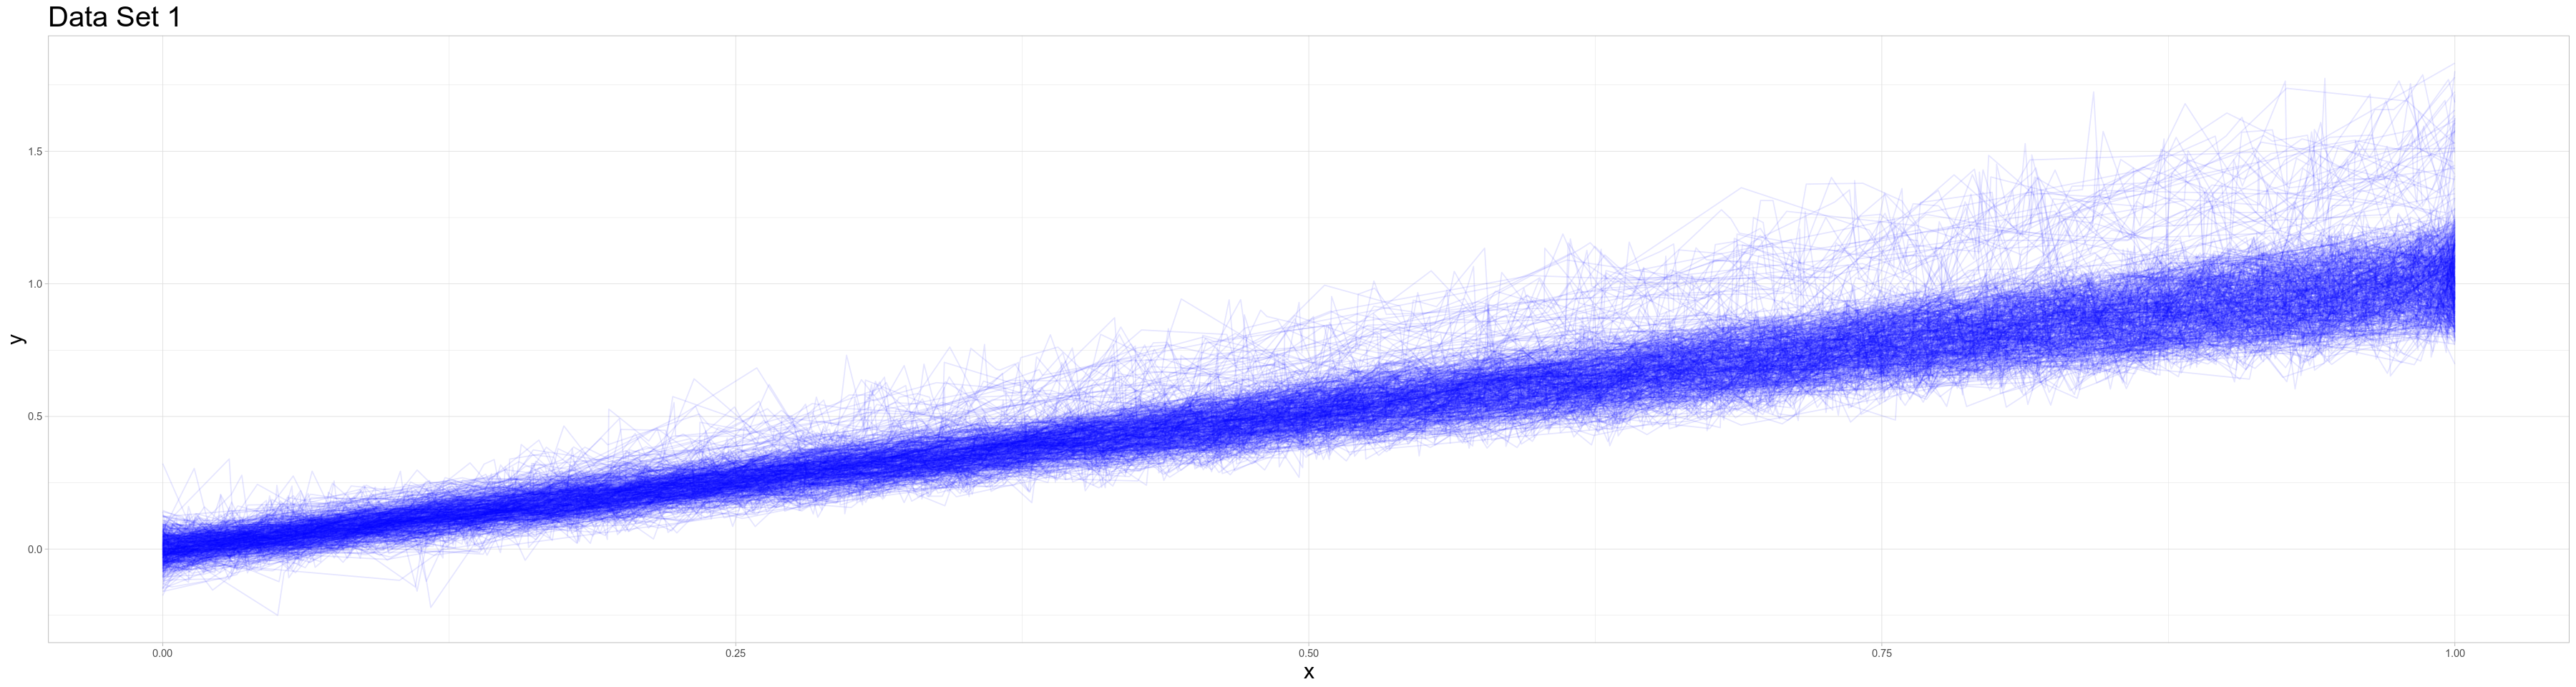

In [2]:
if(file.exists("./data/Set_1/data_obj.RDS")){
   data_set_1 <- readRDS("./data/Set_1/data_obj.RDS")
} else{
    data_set_1 <- OutDetectR::generate_set_1(n_obs = 500)
    saveRDS(data_set_1, file = "./data/Set_1/data_obj.RDS")
}    

if(file.exists("./data/Set_1/tibble.RDS")){
   tidy_set_1 <- readRDS("./data/Set_1/tibble.RDS") 
} else{
   tidy_set_1 <- tidify_1(data_set_1$data, data_set_1$ids)
   saveRDS(object = tidy_set_1, file = "./data/Set_1/tibble.RDS")
}
                        
vis_1(tidy_set_1)  

On a data set of this scale, it is unproblematic to perform the outlier detection procedure as a whole. Therefore, we can just call **detection_wrap()** on the data set with the usual parameter choices and obtain results without having to resort to a sampling approach as is done in the following code snippet.

In [ ]:
if(file.exists("./data/Set_1/detection.RDS")){
    set_1_detection <- readRDS("./data/Set_1/detection.RDS")
} else{
    set_1_detection <- detection_wrap(func_dat = data_set_1$data, alpha = 0.05, B = 50, gamma = 0.05, ids = data_set_1$ids)
    saveRDS(object = set_1_detection, file = "./data/Set_1/detection.RDS")
}

In [ ]:
if(file.exists("./data/Set_1/summary.RDS")){
    set_1_summary <- readRDS("./data/Set_1/summary.RDS")
} else{
    
    missed_outliers = setdiff(data_set_1$outliers, set_1_detection$outlier_ind)
    false_outliers = setdiff(set_1_detection$outlier_ind, data_set_1$outliers)
    
    set_1_summary <- list(flagged = set_1_detection$outlier_ind,
                          original = data_set_1$outliers,
                          missed = missed_outliers,
                          false = false_outliers)
    
    saveRDS(object = set_1_summary, file = "./data/Set_1/summary.RDS")
}

if(file.exists("./data/Set_1/shiny_tibble.RDS")){
    shiny_tibble_1 <- readRDS("./data/Set_1/shiny_tibble.RDS")
} else{
    shiny_tibble_1 <- tidy_set_1 %>%
        mutate(outlier = ifelse(ids %in% data_set_1$outliers, TRUE, FALSE),
               flagged = ifelse(ids %in% set_1_detection$outlier_ind, TRUE, FALSE))
    saveRDS(object = shiny_tibble_1, file = "./data/Set_1/shiny_tibble.RDS")
}

### Sampling <a name="sampling"></a>
---
This second data set consists of 10000 observations where 95% are generated by the same process as the non-outlier variant in the previous data set. 
So a vector of arguments is drawn from the continuous uniform on $[0,1]$ of random length. Call this vector *args* in the following description.

But the outliers take 5 different forms each appearing in about one percent of cases. I will describe their data generating processes in mathematical form in the following:

1. Exactly as the outliers in data set 1.

2. Sigmoid function: $\frac{1}{\mathbb{1} + \exp{(-3 * \text{args})}} + \epsilon$ where $\epsilon$ is a vector of appropriate length containing i.i.d. elements drawn from $\mathcal{N}(0, 0.05^2)$

3. Half sigmoid function: $\frac{2}{\mathbb{1} + \exp{(-3 * \text{args})}} - \mathbb{1} + \epsilon$ where $\epsilon$ is a vector of appropriate length containing i.i.d. elements drawn from $\mathcal{N}(0, 0.05^2)$

4. Exponential function: $\frac{\exp(args) - \mathbb{1}}{e - 1} + \epsilon$ where $\epsilon$ is a vector of appropriate length containing i.i.d. elements drawn from $\mathcal{N}(0, 0.05^2)$

5. Noise: i.i.d. draws from $U[0,1]$

In [2]:
# sample size for sampling procedure
sample_size <- 250
n_obs <- 10000

# generate synthetic test set
if(file.exists("./data/Set_2/data_obs.RDS")){
    data_set_2 <- readRDS(file = "./data/Set_2/data_obs.RDS")

} else{
    data_set_2 <- OutDetectR::generate_set_2(n_obs = 10000)
    saveRDS(data_set_2, "./data/Set_2/data_obs.RDS")
}    

Using the function **OutDetectR::largeListify()** this data is then transformed into an object of type largeList to allow for random access from storage during the sampling procedure.
Due to the frequency of access, it is advisable to use a fast storage solution like an NVMe SSD for this purpose as any latency can drastically increase the time the procedure takes to identify outliers. It would be optimal to keep the data set in memory for the purpose of this algorithm. However, in many setting the subsets of comparable observations could be too big too be kept in memory during the sampling procedure, which is why I decided to implement a method that reads each new sample from storage.

In [3]:
# save in largeList format fast harddrive / SSD
if(!file.exists("./data/Set_2/synth_data.llo")){
    OutDetectR::largeListify(
        func_dat = data_set_2$data, path = './data/Set_2/synth_data.llo'
    )
}

For the sampling procedure, it is necessary to obtain the measuring intervals and to identify the uique measuring intervals that occur in the data set.

In [4]:
# get measuring intervals
synth_ints <- OutDetectR::measuring_int_mat(data_set_2$data)

# get unique measuring intervals
unique_intervals <- OutDetectR::unique_intervals(synth_ints)

Using those inputs, one can create a cluster with the function **makeForkCluster()** and call the sample detection procedure. In the code below, the pure sampling procedure is called via **stretch_sample_detection()** with $\lambda = 1$ as the pure sampling procedure will soon be replaced by a call to this function to reduce the complexity of the code.

However, **makeForkCluster()** is only available on UNIX systems and does not work under Windows. There it can be replaced by **makePSOCKcluster()** and ppropriate calls to export the relevant objects to the cluster.

In [5]:
if(file.exists("./data/Set_2/results.RDS")){
   set_2_results <- readRDS(file = "./data/Set_2/results.RDS")
} else{
    ### Use Sampling procedure for reduced data set
    n_cores <- parallel::detectCores()

    # create cluster
    cl <- makeForkCluster(n_cores - 1)

    # set different seeds just to be sure
    clusterCall(cl = cl, fun = function(i) {
      set.seed(as.numeric(Sys.getpid()))
      print(as.numeric(Sys.getpid()))}
    )

    # try using the sampling procedure
    set_2_results <- OutDetectR::stretch_sample_detection(
      cl = cl, list_path = './data/Set_2/synth_data.llo',
      measuring_intervals = synth_ints, lambda = 1,
      sample_size = sample_size, expn = 10, alpha = 0.05, B = 100, gamma = 0.05,
      debug = FALSE
    )
    saveRDS(set_2_results, file = './data/Set_2/results.RDS')

    stopCluster(cl)
}

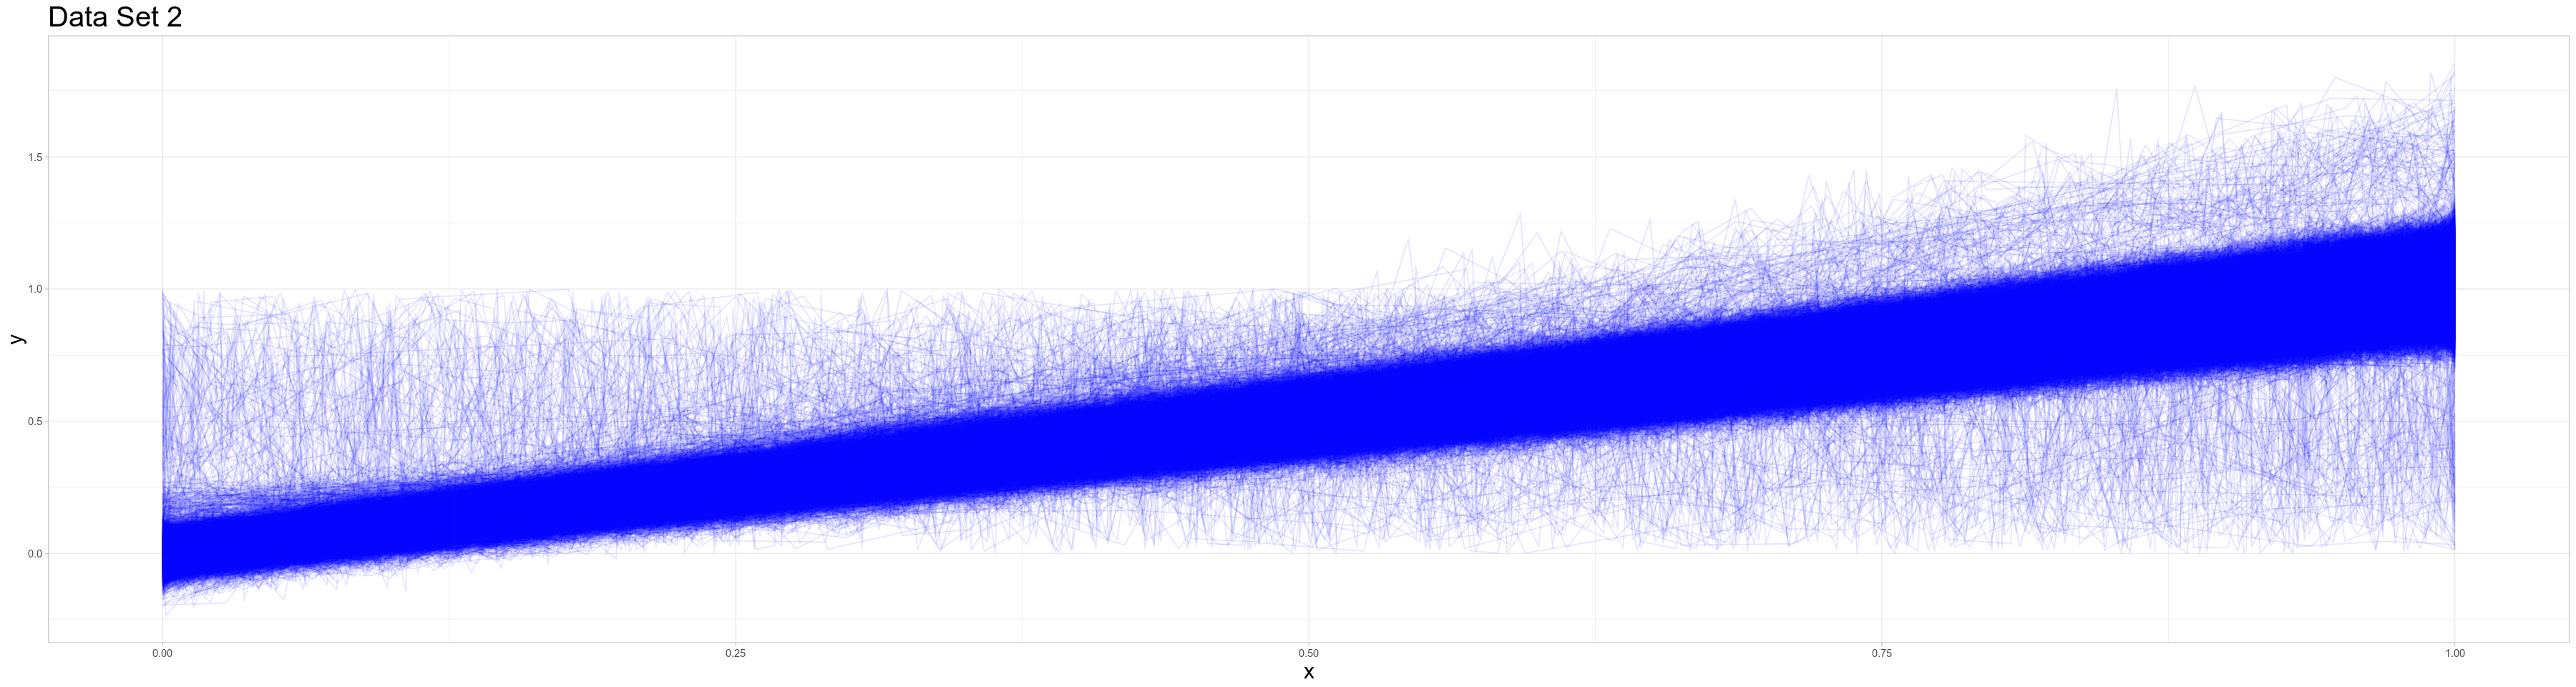

In [6]:
if(file.exists("./data/Set_2/tibble.RDS")){
   tidy_set_2 <- readRDS("./data/Set_2/tibble.RDS") 
} else{
   tidy_set_2 <- tidify_2(data_set_2$data, data_set_2$ids)
   saveRDS(object = tidy_set_2, file = "./data/Set_2/tibble.RDS")
}

vis_2(tidy_set_2)

In [8]:
if(file.exists("./data/Set_2/shiny_tibble.RDS")){
    shiny_tibble_2 <- readRDS("./data/Set_2/shiny_tibble.RDS")
} else{
    shiny_tibble_2 <- tidy_set_2 %>%
        mutate(outlier = ifelse(ids %in% data_set_2$outliers, TRUE, FALSE))
    
    lengths <- unlist(map(.x = 1:10000,
                          .f = function(i) length(data_set_2$data[[i]]$vals)))
                          
    shiny_tibble_2$cert <- unlist(map(.x = 1:10000,
                                      .f = function(i) rep(set_2_results$certainties[i], times = lengths[i])))
    
    saveRDS(object = shiny_tibble_2, file = "./data/Set_2/shiny_tibble.RDS")
}

### Full Procedure: Sampling and Stretching <a name="full"></a>
---
This data set is similar to the sampling data set in its data generating process. There are again 10000 observations each generated by a similar process as in data set 2.

The main difference is, that the measuring intervals are not identical and are drawn from the following possibilities:

| Endpoint of Measuring Interval 	| 0.9  	| 1   	| 1.1  	| 1.5  	| 1.6  	| 1.7  	| 1.9 	| 2    	| 2.1  	|
|:------------------------------:	|------	|-----	|------	|------	|------	|------	|-----	|------	|------	|
|           Probability          	| 0.05 	| 0.2 	| 0.05 	| 0.07 	| 0.15 	| 0.08 	| 0.1 	| 0.25 	| 0.05 	|

Also the data generating processes for both the outliers and the non-outliers are scaled such that the expected realizations at the beginning and end of the data set are identical. (Especially important for the exponential and sigmoidal outliers.) An exception from this are the type 5 outliers, which stay uniformly distributed - but the upper border of the support is made to fit the expected realization of the non-outlier process at the end point of the measuring interval.

In [2]:
# sample size for sampling procedure
sample_size <- 250

if(file.exists("./data/Set_3/data_obj.RDS")){
    data_set_3 <- readRDS(file = "./data/Set_3/data_obj.RDS")
} else{
    data_set_3 <- OutDetectR::generate_set_3(n_obs = 10000)
    saveRDS(data_set_3, file = "./data/Set_3/data_obj.RDS")
}    

if(file.exists("./data/Set_3/tibble.RDS")){
   tidy_set_3 <- readRDS("./data/Set_3/tibble.RDS") 
} else{
   tidy_set_3 <- tidify_3(data_set_3$data, data_set_3$ids)
   saveRDS(object = tidy_set_3, file = "./data/Set_3/tibble.RDS")
}

### Due to a lengthy plotting time and overplotting, this plot is saved an inserted as a png
# vis_3(tidy_set_3)

<img src="material/set_3.png" width="1000" align="center"> 

As in the sampling case, it is necessary to save the data set to storage. This is again done using **largeListify()**.

In [3]:
# save in largeList format fast harddrive / SSD
if(!file.exists("./data/Set_3/synth_data.llo")){
    OutDetectR::largeListify(
        func_dat = data_set_3$data, path = './data/Set_3/synth_data.llo'
    )
}

# get measuring intervals
if(file.exists("./data/Set_3/intervals.RDS")){
    synth_ints <- readRDS("./data/Set_3/intervals.RDS")
} else{
    synth_ints <- OutDetectR::measuring_int_mat(data_set_3$data)
    saveRDS(synth_ints, file = "./data/Set_3/intervals.RDS")
}

# get unique measuring intervals
unique_intervals <- OutDetectR::unique_intervals(synth_ints)

Using the same structure presented in the sampling section, one creates a cluster using **makeForkCluster()** and call **stretch_sample_detection()** with the desired parameters.

In [10]:
if(file.exists("./data/Set_3/results.RDS")){
   set_3_results <- readRDS(file = "./data/Set_3/results.RDS")
} else{
    ### Use Sampling procedure for reduced data set
    n_cores <- parallel::detectCores()

    # create cluster
    cl <- makeForkCluster(n_cores - 1)

    # set different seeds just to be sure
    clusterCall(cl = cl, fun = function(i) {
      set.seed(as.numeric(Sys.getpid()))
      print(as.numeric(Sys.getpid()))}
    )
    
    set_3_results <- OutDetectR::stretch_sample_detection(
      cl = cl, list_path = './data/Set_3/synth_data.llo',
      measuring_intervals = synth_ints, lambda = 1.2,
      sample_size = sample_size, expn = 8, alpha = 0.05, B = 100, gamma = 0.05,
      debug = FALSE
    )
    saveRDS(set_3_results, file = './data/Set_3/results.RDS')
    
    stopCluster(cl)
}    

Running this code in RStudio with the argument **debug = TRUE** gives outputs as shown in the following image. Future revisions could incorporate features such as progress bars or futher information on the sampling process for each individual measuring interval.

<img src="material/rstudio_stretch_sample_run.png" width="1000" align="center">

In [6]:
if(file.exists("./data/Set_3/shiny_tibble.RDS")){
    shiny_tibble_3 <- readRDS("./data/Set_3/shiny_tibble.RDS")
} else{
    shiny_tibble_3 <- tidy_set_3 %>%
        mutate(outlier = ifelse(ids %in% data_set_3$outliers, TRUE, FALSE))
    
    lengths <- unlist(map(.x = 1:10000,
                          .f = function(i) length(data_set_3$data[[i]]$vals)))
                          
    shiny_tibble_3$cert <- unlist(map(.x = 1:10000,
                                      .f = function(i) rep(set_3_results$certainties[i], times = lengths[i])))
    
    saveRDS(object = shiny_tibble_3, file = "./data/Set_3/shiny_tibble.RDS")
}

### Updating in the Full Procedure <a name="upd_full"></a>
---
Using the data and results from the third setting shown above [Full Procedure: Sampling and Stretching](#full), it is now possible to show how the updating procedure works for a single new observation. As the updating procedure assumes that new observations are added sequentially, adding multiple new observations could be done as a sequential process of adding new observations but different, less computationally intensive procedures are conceivable.

As a first step, we need the results, parameters and measureing intervals from the previous runs.

In [ ]:
# sample size for sampling procedure
sample_size <- 250

# generate new observation
new_obj <- generate_set_3(n_obs = 1)$data[[1]]

# get measuring intervals
synth_ints <- readRDS("./data/Set_3/intervals.RDS")

# get unique measuring intervals
unique_intervals <- OutDetectR::unique_intervals(synth_ints)

# load results from original test
set_3_results <- readRDS(file = './data/Set_3/results.RDS')

The updating process is the very similar to the original outlier classification and therefore follows a similar code structure. Bear in mind that at this stage of the process, the new observation should not yet be added to the largeList object.

In [13]:
if(file.exists("./data/Set_3/update_results.RDS")){
   update_results <- readRDS(file = "./data/Set_3/update_results.RDS")
} else{
    ### Use Sampling procedure for reduced data set
    n_cores <- parallel::detectCores()

    # create cluster
    cl <- makeForkCluster(n_cores - 1)

    # set different seeds just to be sure
    clusterCall(cl = cl, fun = function(i) {
      set.seed(as.numeric(Sys.getpid()))
      print(as.numeric(Sys.getpid()))}
    )
    
    # run updating procedure
    update_results <- OutDetectR::stretch_sample_updating(
      cl = cl, new_observation = new_obj, list_path = './data/Set_3/synth_data.llo', 
      lambda = 1.2, measuring_intervals = synth_ints, sample_size = sample_size, expn = 8, 
      alpha = 0.05, B = 100, gamma = 0.05, num_samples_prev = set_3_results$num_samples, 
      num_outliers_prev = set_3_results$num_outliers, debug = TRUE)

    stopCluster(cl)
    
    readRDS(file = "./data/Set_3/update_results.RDS")
}   

 Once the results have been updated to incorporate the new observation, it is possible to append it to the largeList object on the harddrive using the provided function **append_obs()**.

In [ ]:
if(FALSE){
    append_obs(func_obs = new_obs, path = './data/Set_3/synth_data.llo')
}

It is interesting to take a look the difference between the results before and after updating.

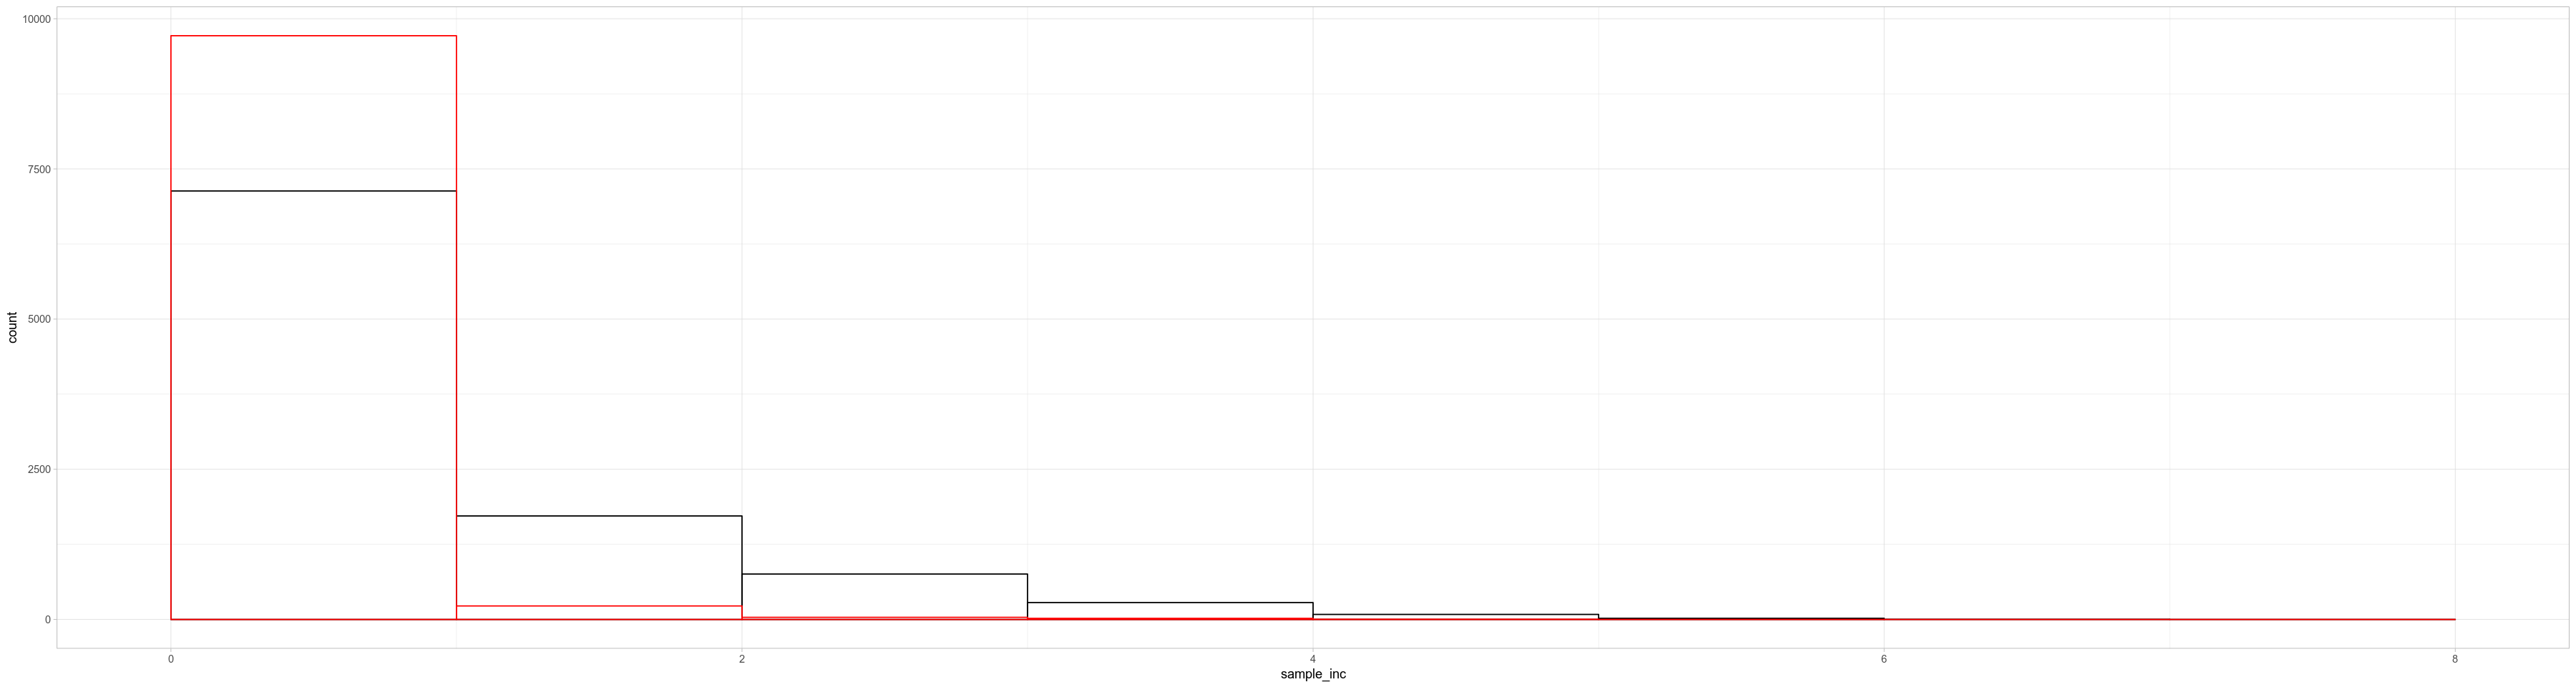

In [35]:
(tibble(observation = 1:10000,
       n_samples_before = c(set_3_results$num_samples),
       n_outliers_before = c(set_3_results$num_outliers),
       n_samples_after = update_results$num_samples[1:10000],
       n_outliers_after = update_results$num_outliers[1:10000]) %>%
    mutate(sample_inc = n_samples_after - n_samples_before,
           outlier_inc = n_outliers_after - n_outliers_before) %>%
    ggplot() +
        geom_histogram(aes(x = sample_inc), binwidth = 1, boundary = 0, col = 'black', fill = NA, position="identity") +
        geom_histogram(aes(x = outlier_inc), binwidth = 1, boundary = 0, col = 'red', fill = NA, position="identity") +
        theme_light()
)

The diagram above shows the distribution of how often the original observations were chosen for the sampling procedure during the update. As can be seen, most observations are not chosen in additional samples. However, as the number of observations increases during a sequential updating process, the originally chosen parameter **expn** from the sampling and stretching procedure might have to be updated to reflect the increased number of samples each observation was a part of. This could be an extension for future work on the sequential updating procedure.

## Endanzug-Data <a name="application"></a>
---
When applying the procedure to the real world data from the Endanzug dataset, I decided to use a subset of 20000 randomly chosen observations. Using the whole dataset is unfeasible with a typical computer and would require further optimizations and the usage of high-performance computing.

In [ ]:
if (real_data) {
    
    # sample size for sampling procedure
    sample_size <- 1000

    # load real Endanzug-Data if possible
    endanzug_data <- readRDS(file = paste0(endanzug_path, 'schra.RDS'))

    # extract observation angles and torque
    grids <- endanzug_data$aArr_endanzug
    vals <- endanzug_data$mArr_endanzug
}

In [ ]:
if (real_data) {
    # select subset to test the algorithm
    set.seed(42)
    n <- 20000
    test_set <- sort(
      sample(x = 1:dim(endanzug_data)[1], size = n, replace = FALSE)
    )

    # save test indexes
    saveRDS(test_set, file = paste0('endanzug_path', 'test_ids.RDS'))

    # extract corresponding grids, vals and ids
    test_grids <- grids[test_set]
    test_vals <- vals[test_set]
    test_ids <- endanzug_data[test_set, "prodNo"]

    # bring the test_observations into the usual format
    test_data <- purrr::map(
      .x = 1:n,
      .f = function(i) list(args = grids[[i]], vals = vals[[i]])
    )
    
    # save partial data
    saveRDS(test_set, file = paste0('endanzug_path', 'schra_partial.RDS'))
}

In [ ]:
if (real_data) {
    # zero observations to allow for stretching
    test_data_zero <- OutDetectR::zero_data(test_data)
    
    # save zeroed partial data
    saveRDS(test_set, file = paste0('endanzug_path', 'schra_partial_zero.RDS'))
    
    # save data as largeList for further processing
    OutDetectR::largeListify(
      func_dat = test_data_zero,
      path = paste0(endanzug_path, "test_red_data.llo")
    )
}

In [ ]:
if (real_data) {
    # get measuring intervals from test data
    test_ints <- OutDetectR::measuring_int_mat(test_data_zero)

    # find unique measuring intervals in data set
    unique_intervals <- OutDetectR::unique_intervals(test_ints)
}

In [ ]:
if (real_data) {
    # Use Sampling procedure for reduced data set
    # create cluster - probably decrease number of threads. 
    # This is memory intensive
    cl <- makeForkCluster(parallel::detectCores() - 1)

    # set different seeds just to be sure
    clusterCall(cl = cl, fun = function(i) {
      set.seed(as.numeric(Sys.getpid()))}
    )

    # try using the sampling procedure
    test_procedure <- OutDetectR::stretch_sample_detection(
      cl = cl, list_path = paste0(endanzug_path, "test_red_data.llo"),
      measuring_intervals = test_ints, lambda = 1.05,
      sample_size = sample_size, expn = 7, alpha = 0.05, B = 50, gamma = 0.05,
      debug = FALSE
    )

    stopCluster(cl)

    saveRDS(test_procedure, file = paste0('endanzug_path', 'stretch_sample_test.RDS'))
}

## Limitations <a name="limitations"></a>
---
<img src="material/real_data_plot.png" width="1000" align="center">

## Shiny App <a name="shiny"></a>
---
Instead of presenting the visualizations for the classification procedure in static graphics, I decided to use a shiny web app instead. This has multiple advantages in the setting of this final project, but the main motivation behind it was the use case described to me:<br> **An engineer wants to get a preselection of suspicious observations they should have a look at.**

In this context, having a raw R file as output without an easy way to interact with it, would not be particularly useful. Instead, being able to run this shiny app on a local server with the precalculated values stored in a database, would be more in line with the idea of the job. This also motivates the features I implemented for the app (and plan to implement in future updates) like:
* setting the focus to single observations
* changing the plotting window
* changing the centrainty threshold for observations to be classified as atypical

etc.

To start the shiny app, I recommend cloning this repository and executing the file **app.R** locally. This will start the shiny app on a local server. Instead, one can choose to use the **binder** button on the repo site to start it. Due to a lengthy build process, this is not the recommended way to look at it.

The shiny app serves as the visualization for all results of the previously explained simulation studies and shows what a possible deployment of the method in a real world scenario could look like.

## Outlook <a name="outlook"></a>
---
The current state of the project and the implementation can serve as an example for the capabilities of the functional depth approach described by Febrero-Bande, Galeano, and Gonzàlez-Manteiga (2008).

### Generalizations
As described in a previous section, the method described in this project for data sets which allow for zeroing of the observations could be generalized by introducing another parameter **acceptable shifting** in addition to **acceptable stretching**. This could then be used to define a method that finds comparable subsets in data sets that do not allow zeroing. As this introduces more variables and makes a more sophisticated splitting algorithm necessary, it was out of the scope of this project, but will be addressed in the future.

### Parameter Choice
An important part of this procedure will be the choice of its tuning parameters: 
* In its purest form the algorithm needs a choice for $\alpha$, $\gamma$, $B$ and a grid to use for approximation purposes
* Adding sampling adds the choice of sample size and number of samples
* The full procedure then additionally needs $\lambda$

Some of these like sample size and number of samples could be made dependent on the structure of comparable subsets and even change when switching from one comparable subset to the next. One goal of this could be to make each observation appear in a similar number of samples overall. But other reasonable procedures are possible. <br>
Others like $\alpha$ and $\lambda$ could be chosen by a simulation method. Constructing a similar but smaller data set with intentionally added outliers to perform cross validation or a similar procedure could be an approach for this case. A more sophisticated and detailed description of this method will be part of future revisions.

### Performance Measures for the Algorithm & Benchmarking
Tightly connected to the point of parameter choice is the question of how to measure the performance of the outlier detection procedure in different settings. 
* First, I am going to look for existing data sets that are commonly used to benchmark outlier classification procedures. The performance of this algorithm in these preclassified settings can serve as grounds for determining in which cases and using which parameter choices the method performs well and compare it to existing methods that are applicable in comparable scenarios. <br>
* Second, as can be seen by the previously generated data, an ex ante classification of realizations created by different dgps may not appropriately cover the idea of outlyingness. Some realizations in previous data sets look very typical for the non-outlier dgp and a classification as atypical due to the different dgp could lead to an underestimation of the procedures performance. Therefore, a comparison to established methods can serve as a better tool to judge the effectiveness.

### Identifying what contributes to outlyingness of an observation
Once atypical observations in a data set are identified, it is very interesting to see what contributes to their outlyingness in the eyes of the algorithm. To create some ex-post explanation for why a classification decision was made would be a useful tool to inform future real-world decisions or improve the procedure itself by incorporating that information into the mechanism. Some interesting approaches to create an ex-post explanation are the following:

1. Create slightly altered realizations of an observation that has been marked as an outlier and see what effect different alterations have on its classification (or certainty in case of the sampling-based methods).
2. Compare locally similar observations that have different outcomes in the overall procedure.

There are more ways to gain information on what features contribute to outlyingness, but due to the current scope of this project, more in-depth considerations of this approach will only be part of future revisions.

### Improvements to the Shiny App
The shiny app, which currently serves as a prototype for how this method could be used in a production context, could be extended and improved starting with changes to which observations are plotted when focus is set to a single observation. In this case for example plotting more observations in the close vicinity of the observation might be of greater interest, whereas observations farther away may provide little information of use and could be plotted less frequently to avoid overplotting. <br>
Due to the interactive process of designing an interface that is meant for direct interaction with the user, it is difficult to predict the exact nature of the changes as these could be made according to user requests.

## Sources <a name="sources"></a>
---
* Cuevas, A. & Febrero-Bande, M. & Fraiman, R. (2006). On the use of bootstrap for estimating functions with functional data. Computational Statistics & Data Analysis. 51. 1063-1074.
* Febrero-Bande, M. & Galeano, P. & Gonzàlez-Manteiga, W. (2008). Outlier detection in functional data by depth measures, with application to identify abnormal NOx levels. Environmetrics. 19. 331 - 345.
* Gijbels, I. & Nagy, S. (2017). On a General Definition of Depth for Functional Data. Statistical Science. 32. 630-639.

---

Notebook by **Jakob R. Jürgens** <br>
Final project for the courses **OSE - Data Science** in the summer semester 2021 and **OSE - Scientific Computing** in the winter semester 2021/2022<br>
Find me at [jakobjuergens.com](https://jakobjuergens.com)